In [193]:
# fatigue_analysis.ipynb

from pymongo import MongoClient
import pandas as pd
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import cross_val_score, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.pipeline import Pipeline
import pickle
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from scipy.stats import ttest_ind, ttest_rel, wilcoxon
import joblib
import statsmodels.api as sm
import statsmodels.formula.api as smf
import chess
import chess.engine
import pymc as pm

In [83]:
load_dotenv()

MONGO_URL = os.getenv("MONGO_URL")
client = MongoClient(MONGO_URL)
db = client["fatigue"]

# Load collections
rested = list(db["rested"].find())
tired1 = list(db["tired1"].find())

rested_df = pd.DataFrame(rested)
tired1_df = pd.DataFrame(tired1)

rested_df.head()



,_id,participantCode,survey,towerOfLondon,matchPairs,stroop,winsconsin,chess
0,6803e76988cfca27f566e556,CGYS2MPAY,"{'q0': 'q0o1', 'q1': 'q1o3', 'q2': 'q2o3', 'q3...","[{'puzzle': 0, 'moves': 47, 'timeMs': 98656}, ...","{'time': 44, 'mistakes': 8}","{'trials': [{'trial': 1, 'word': 'Blue', 'font...","[{'card': {'shape': 'cross', 'color': 'red', '...","[{'game': 1, 'result': 'loss', 'difficulty': 1..."
1,6804bddc16308b31c0cbe155,C920D5GLC,"{'q0': 'q0o1', 'q1': 'q1o2', 'q2': 'q2o3', 'q3...","[{'puzzle': 0, 'moves': 47, 'timeMs': 164240},...","{'time': 54, 'mistakes': 10}","{'trials': [{'trial': 1, 'word': 'Zielony', 'f...","[{'card': {'shape': 'star', 'color': 'red', 'n...","[{'game': 1, 'result': 'loss', 'difficulty': 5..."
2,6804d60097dd9f9252971d96,C03RMJ75X,"{'q0': 'q0o3', 'q1': 'q1o2', 'q2': 'q2o2', 'q3...","[{'puzzle': 0, 'moves': 107, 'timeMs': 249975}...","{'time': 49, 'mistakes': 8}","{'trials': [{'trial': 1, 'word': 'Zielony', 'f...","[{'card': {'shape': 'circle', 'color': 'green'...","[{'game': 1, 'result': 'loss', 'difficulty': 0..."
3,68087fad9cfeeaabf8ff3191,C8DPGBOM9,"{'q0': 'q0o1', 'q1': 'q1o3', 'q2': 'q2o3', 'q3...","[{'puzzle': 0, 'moves': 38, 'timeMs': 71616}, ...","{'time': 57, 'mistakes': 13}","{'trials': [{'trial': 1, 'word': 'Niebieski', ...","[{'card': {'shape': 'star', 'color': 'yellow',...","[{'game': 1, 'result': 'loss', 'difficulty': 3..."
4,680a1c9eb580916bec09f3d6,CNUFYKKGE,"{'q0': 'q0o1', 'q1': 'q1o2', 'q2': 'q2o2', 'q3...","[{'puzzle': 0, 'moves': 45, 'timeMs': 256245},...","{'time': 57, 'mistakes': 11}","{'trials': [{'trial': 1, 'word': 'Niebieski', ...","[{'card': {'shape': 'cross', 'color': 'yellow'...","[{'game': 1, 'result': 'loss', 'difficulty': 5..."


In [84]:
tired1_df.head()

,_id,participantCode,survey,towerOfLondon,matchPairs,stroop,winsconsin,chess
0,68091fa92adbc6aad0635ba6,C8DPGBOM9,"{'q0': 'q0o1', 'q1': 'q1o3', 'q2': 'q2o3', 'q3...","[{'puzzle': 2, 'moves': 63, 'timeMs': 119872},...","{'time': 42, 'mistakes': 8}","{'trials': [{'trial': 1, 'word': 'Żółty', 'fon...","[{'card': {'shape': 'triangle', 'color': 'red'...","[{'game': 1, 'result': 'loss', 'difficulty': 0..."
1,680d34646ef0bb36c055dc11,C920D5GLC,"{'q0': 'q0o1', 'q1': 'q1o2', 'q2': 'q2o3', 'q3...","[{'puzzle': 2, 'moves': 64, 'timeMs': 141271},...","{'time': 58, 'mistakes': 14}","{'trials': [{'trial': 1, 'word': 'Czerwony', '...","[{'card': {'shape': 'triangle', 'color': 'red'...","[{'game': 1, 'result': 'loss', 'difficulty': 3..."
2,680d80b2fa22f88662ba4617,CNUFYKKGE,"{'q0': 'q0o1', 'q1': 'q1o2', 'q2': 'q2o2', 'q3...","[{'puzzle': 2, 'moves': 52, 'timeMs': 147228},...","{'time': 46, 'mistakes': 9}","{'trials': [{'trial': 1, 'word': 'Niebieski', ...","[{'card': {'shape': 'circle', 'color': 'green'...","[{'game': 1, 'result': 'loss', 'difficulty': 3..."
3,680e9ce40bb09418a9bbc1d1,CKUSXOY51,"{'q0': 'q0o1', 'q1': 'q1o2', 'q2': 'q2o2', 'q3...","[{'puzzle': 2, 'moves': 34, 'timeMs': 111002},...","{'time': 55, 'mistakes': 7}","{'trials': [{'trial': 1, 'word': 'Zielony', 'f...","[{'card': {'shape': 'star', 'color': 'red', 'n...","[{'game': 1, 'result': 'loss', 'difficulty': 4..."
4,680ff37df9287ed4ce7f5a53,C03RMJ75X,"{'q0': 'q0o3', 'q1': 'q1o2', 'q2': 'q2o2', 'q3...","[{'puzzle': 2, 'moves': 38, 'timeMs': 92640}, ...","{'time': 55, 'mistakes': 9}","{'trials': [{'trial': 1, 'word': 'Czerwony', '...","[{'card': {'shape': 'circle', 'color': 'red', ...","[{'game': 1, 'result': 'loss', 'difficulty': 0..."


In [85]:
rested_codes = set(rested_df['participantCode'])
tired1_codes = set(tired1_df['participantCode'])

common_codes = rested_codes & tired1_codes

rested_common = rested_df[rested_df['participantCode'].isin(common_codes)].copy()
tired1_common = tired1_df[tired1_df['participantCode'].isin(common_codes)].copy()

rested_common.sort_values(by="participantCode", inplace=True)
tired1_common.sort_values(by="participantCode", inplace=True)


In [86]:
def extract_matchpairs(df, label):
    data = []
    for _, row in df.iterrows():
        code = row['participantCode']
        mp = row.get('matchPairs', {})
        time = mp.get('time', None)
        mistakes = mp.get('mistakes', None)
        if time is not None and mistakes is not None:
            data.append({
                'participantCode': code,
                'condition': label,
                'time_ms': time,
                'mistakes': mistakes
            })
    return pd.DataFrame(data)

mp_rest = extract_matchpairs(rested_common, 'rested')
mp_tired = extract_matchpairs(tired1_common, 'tired')

matchpairs_df = pd.concat([mp_rest, mp_tired], ignore_index=True)


<Figure size 1000x500 with 0 Axes>

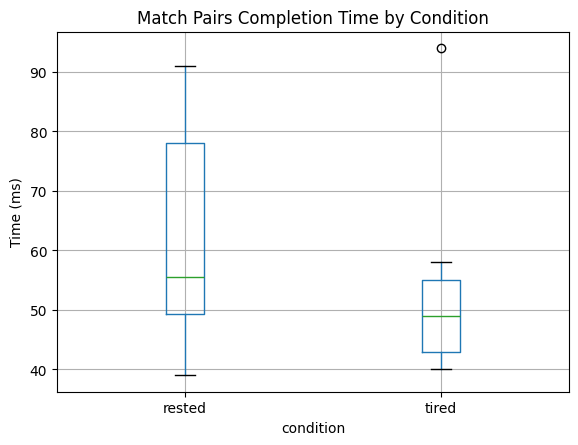

<Figure size 1000x500 with 0 Axes>

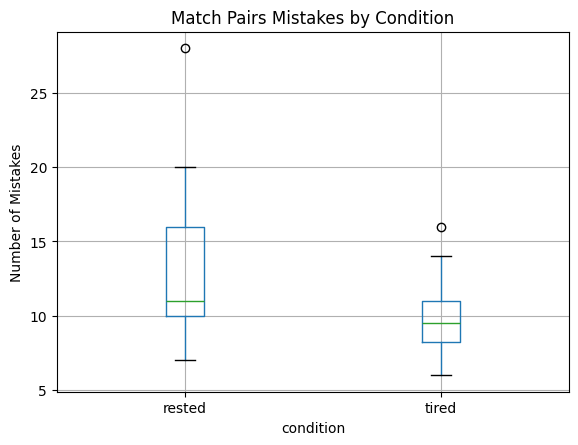

In [87]:
plt.figure(figsize=(10, 5))
matchpairs_df.boxplot(column='time_ms', by='condition')
plt.title("Match Pairs Completion Time by Condition")
plt.suptitle("")
plt.ylabel("Time (ms)")
plt.show()

plt.figure(figsize=(10, 5))
matchpairs_df.boxplot(column='mistakes', by='condition')
plt.title("Match Pairs Mistakes by Condition")
plt.suptitle("")
plt.ylabel("Number of Mistakes")
plt.show()


In [88]:
mp_pivot = matchpairs_df.pivot(index='participantCode', columns='condition', values=['time_ms', 'mistakes'])

mp_pivot = mp_pivot.dropna()

mp_pivot['time_diff'] = mp_pivot[('time_ms', 'tired')] - mp_pivot[('time_ms', 'rested')]
mp_pivot['mistakes_diff'] = mp_pivot[('mistakes', 'tired')] - mp_pivot[('mistakes', 'rested')]

mp_pivot[['time_diff', 'mistakes_diff']].describe()


,time_diff,mistakes_diff
condition,,
count,10.000000,10.000000
mean,-9.200000,-3.400000
std,18.665476,6.397916
min,-45.000000,-17.000000
25%,-14.000000,-4.750000
50%,-5.500000,-3.000000
75%,3.750000,0.500000
max,13.000000,4.000000


# Stroop

In [89]:

# Extract Stroop stats for rested and tired1 participants
def extract_stroop_stats(df, label):
    data = []
    for _, row in df.iterrows():
        stroop = row.get('stroop', {})
        trials = stroop.get('trials', [])
        if not trials:
            continue

        times = [trial['timeMs']['$numberInt'] if isinstance(trial['timeMs'], dict) else trial['timeMs']
                 for trial in trials]
        corrects = [trial.get('correct', False) for trial in trials]
        mistakes = sum(1 for correct in corrects if not correct)
        avg_time = np.mean([int(t) for t in times])

        data.append({
            'participantCode': row['participantCode'],
            f'{label}_avg_time': avg_time,
            f'{label}_mistakes': mistakes,
        })
    return pd.DataFrame(data)

rested_stroop = extract_stroop_stats(rested_common, 'rested')
tired_stroop = extract_stroop_stats(tired1_common, 'tired')




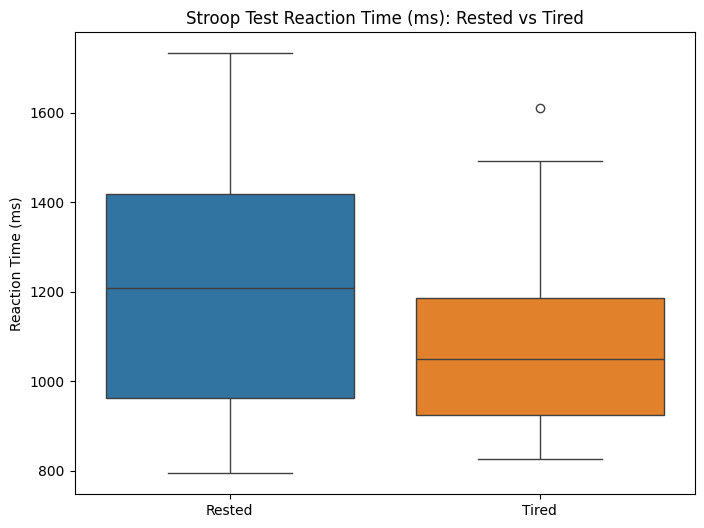

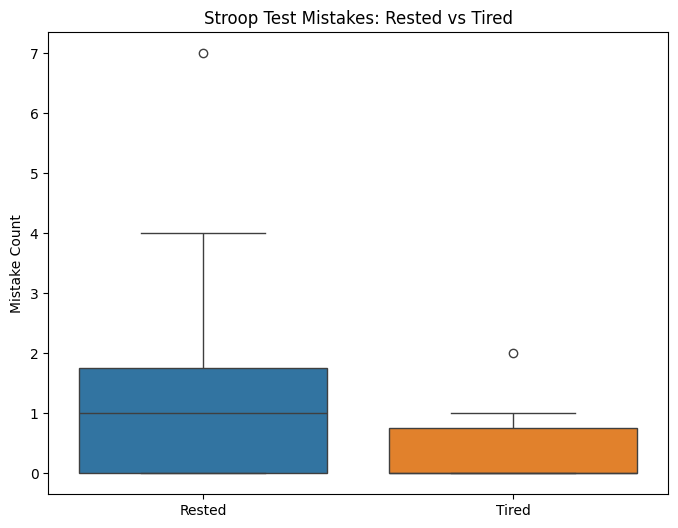

,rested_avg_time,tired_avg_time,rested_mistakes,tired_mistakes
count,10.000000,10.000000,10.000000,10.000000
mean,1225.853333,1106.933333,1.600000,0.400000
std,307.883661,265.688856,2.270585,0.699206
min,794.500000,826.666667,0.000000,0.000000
25%,962.958333,923.525000,0.000000,0.000000
50%,1207.216667,1050.100000,1.000000,0.000000
75%,1417.900000,1185.525000,1.750000,0.750000
max,1732.266667,1610.533333,7.000000,2.000000


In [90]:
# Merge by participantCode
stroop_comparison = pd.merge(rested_stroop, tired_stroop, on='participantCode')

# Plot average time comparison
plt.figure(figsize=(8, 6))
sns.boxplot(data=stroop_comparison[['rested_avg_time', 'tired_avg_time']])
plt.title('Stroop Test Reaction Time (ms): Rested vs Tired')
plt.ylabel('Reaction Time (ms)')
plt.xticks([0, 1], ['Rested', 'Tired'])
plt.show()

# Plot mistake comparison
plt.figure(figsize=(8, 6))
sns.boxplot(data=stroop_comparison[['rested_mistakes', 'tired_mistakes']])
plt.title('Stroop Test Mistakes: Rested vs Tired')
plt.ylabel('Mistake Count')
plt.xticks([0, 1], ['Rested', 'Tired'])
plt.show()

# Optional: print summary stats
stroop_comparison[['rested_avg_time', 'tired_avg_time', 'rested_mistakes', 'tired_mistakes']].describe()

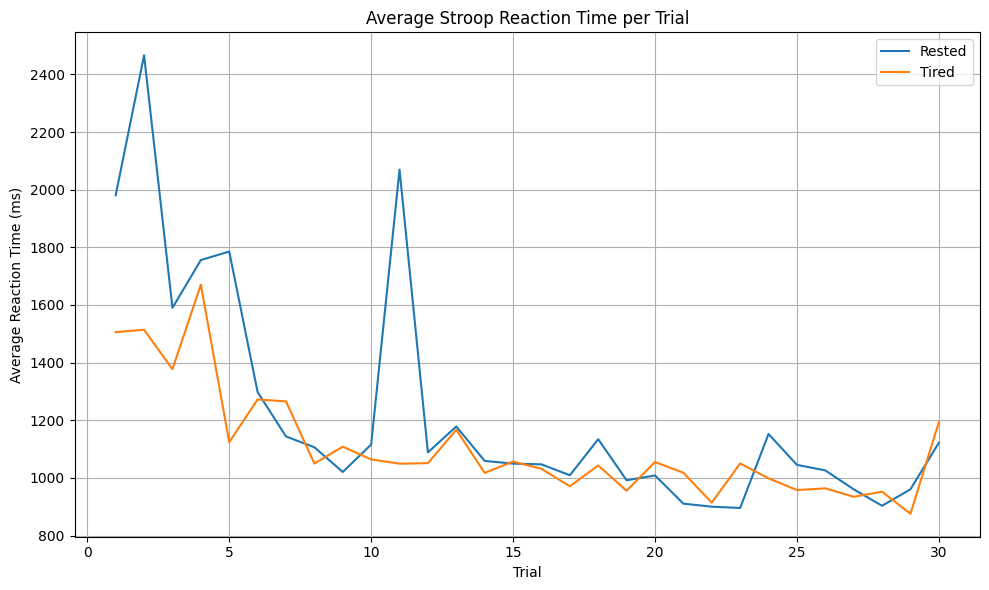

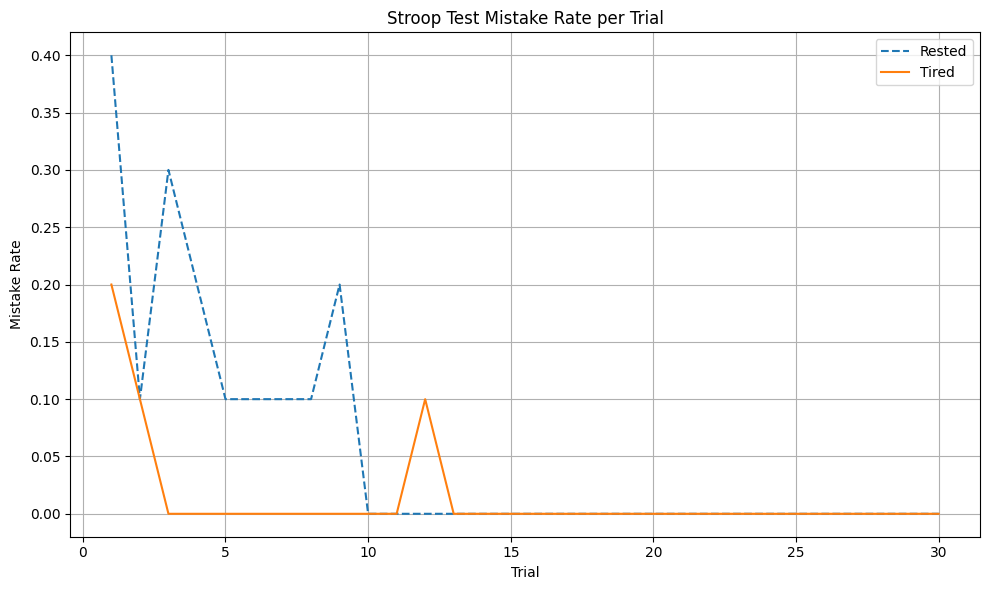

In [91]:
# Create a long-format dataframe with per-trial data
stroop_trials = []

for _, row_rest in rested_common.iterrows():
    code = row_rest['participantCode']
    row_tired = tired1_common[tired1_common['participantCode'] == code]
    if row_tired.empty:
        continue

    trials_rest = row_rest.get('stroop', {}).get('trials', [])
    trials_tired = row_tired.iloc[0].get('stroop', {}).get('trials', [])

    # Use the shortest list to prevent index errors (in case of early termination)
    num_trials = min(len(trials_rest), len(trials_tired))
    
    for i in range(num_trials):
        t_rest = trials_rest[i]
        t_tired = trials_tired[i]

        def safe_get_time(trial):
            t = trial.get('timeMs')
            return int(t['$numberInt']) if isinstance(t, dict) else int(t)

        stroop_trials.append({
            'participantCode': code,
            'trial': i + 1,
            'rested_time': safe_get_time(t_rest),
            'tired_time': safe_get_time(t_tired),
            'rested_correct': t_rest.get('correct', False),
            'tired_correct': t_tired.get('correct', False),
        })

# Create DataFrame
stroop_trials_df = pd.DataFrame(stroop_trials)

# Average reaction time per trial (across participants)
avg_trial_times = stroop_trials_df.groupby("trial")[["rested_time", "tired_time"]].mean().reset_index()

# Line plot of reaction times
plt.figure(figsize=(10, 6))
plt.plot(avg_trial_times['trial'], avg_trial_times['rested_time'], label='Rested')
plt.plot(avg_trial_times['trial'], avg_trial_times['tired_time'], label='Tired')
plt.xlabel("Trial")
plt.ylabel("Average Reaction Time (ms)")
plt.title("Average Stroop Reaction Time per Trial")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: mistake rate per trial
def error_rate(col):
    return 1 - stroop_trials_df.groupby("trial")[col].mean()

trial_mistake_rates = pd.DataFrame({
    'trial': stroop_trials_df['trial'].unique(),
    'rested_error_rate': error_rate("rested_correct").values,
    'tired_error_rate': error_rate("tired_correct").values,
})

# Plot mistake rate
plt.figure(figsize=(10, 6))
plt.plot(trial_mistake_rates['trial'], trial_mistake_rates['rested_error_rate'], label='Rested', linestyle='--')
plt.plot(trial_mistake_rates['trial'], trial_mistake_rates['tired_error_rate'], label='Tired', linestyle='-')
plt.xlabel("Trial")
plt.ylabel("Mistake Rate")
plt.title("Stroop Test Mistake Rate per Trial")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


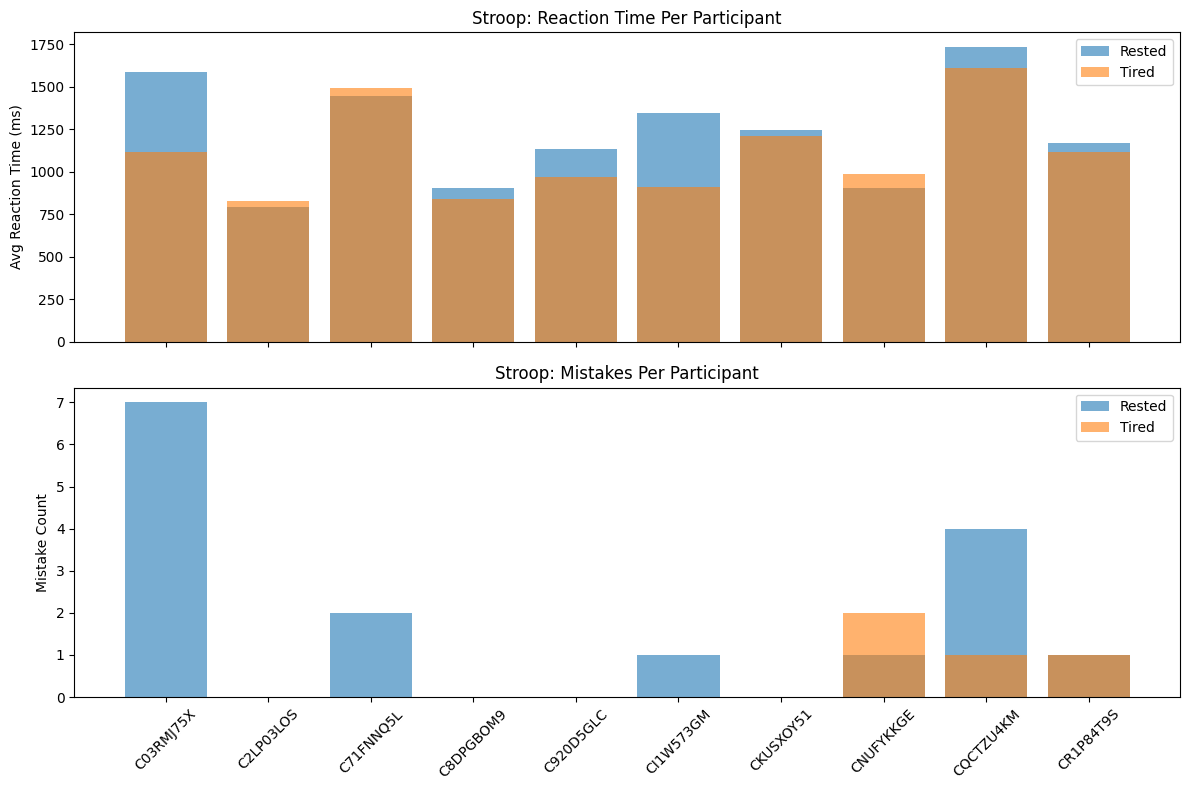

In [92]:
# Grouped individual summary per participant
individual_summary = stroop_trials_df.groupby('participantCode').agg({
    'rested_time': 'mean',
    'tired_time': 'mean',
    'rested_correct': lambda x: (~x).sum(),  # count mistakes
    'tired_correct': lambda x: (~x).sum(),
}).reset_index()

individual_summary.rename(columns={
    'rested_time': 'avg_rested_time',
    'tired_time': 'avg_tired_time',
    'rested_correct': 'rested_mistakes',
    'tired_correct': 'tired_mistakes'
}, inplace=True)

# Bar plots for each participant
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Reaction time comparison
axs[0].bar(individual_summary['participantCode'], individual_summary['avg_rested_time'], label='Rested', alpha=0.6)
axs[0].bar(individual_summary['participantCode'], individual_summary['avg_tired_time'], label='Tired', alpha=0.6)
axs[0].set_ylabel("Avg Reaction Time (ms)")
axs[0].set_title("Stroop: Reaction Time Per Participant")
axs[0].legend()

# Mistakes comparison
axs[1].bar(individual_summary['participantCode'], individual_summary['rested_mistakes'], label='Rested', alpha=0.6)
axs[1].bar(individual_summary['participantCode'], individual_summary['tired_mistakes'], label='Tired', alpha=0.6)
axs[1].set_ylabel("Mistake Count")
axs[1].set_title("Stroop: Mistakes Per Participant")
axs[1].legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


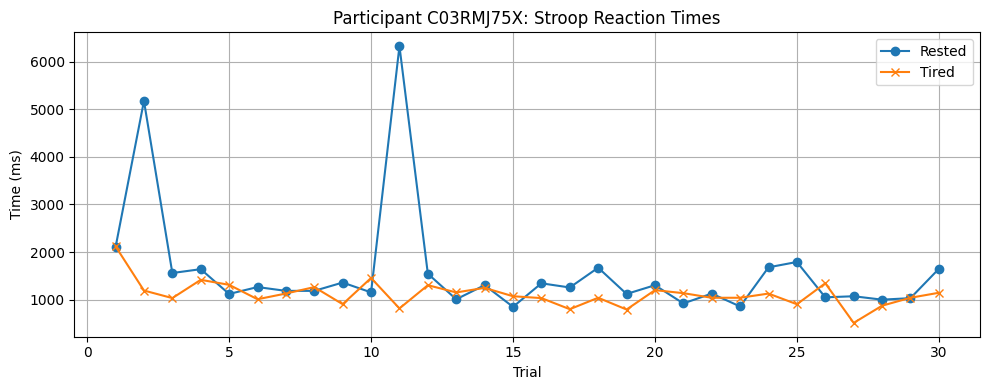

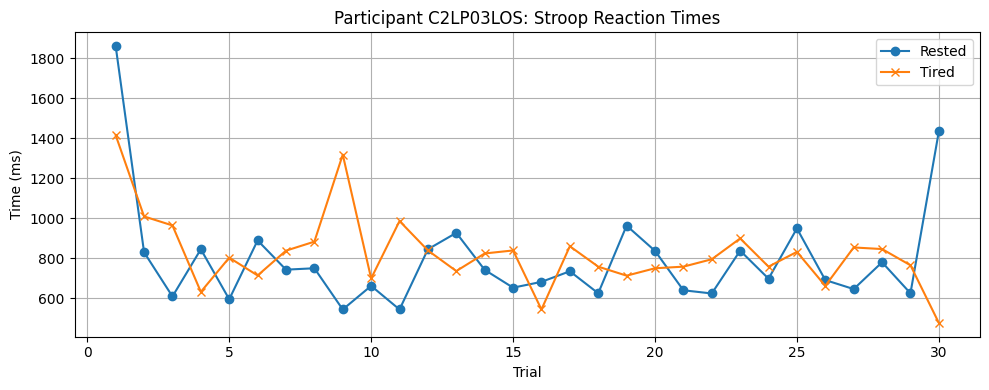

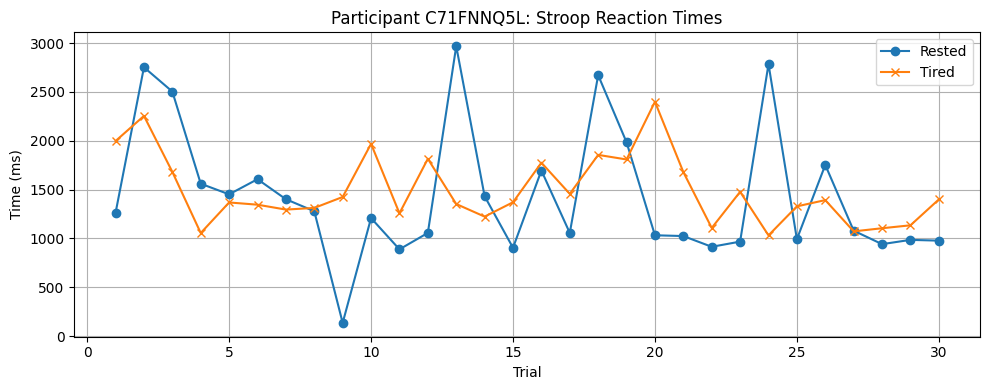

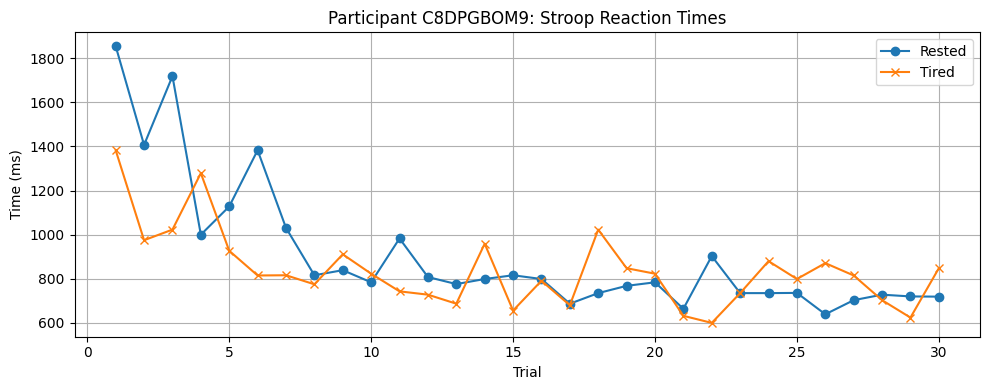

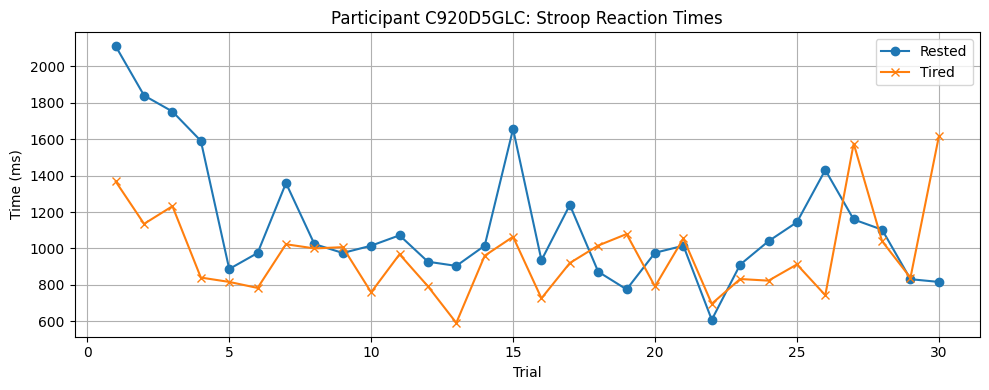

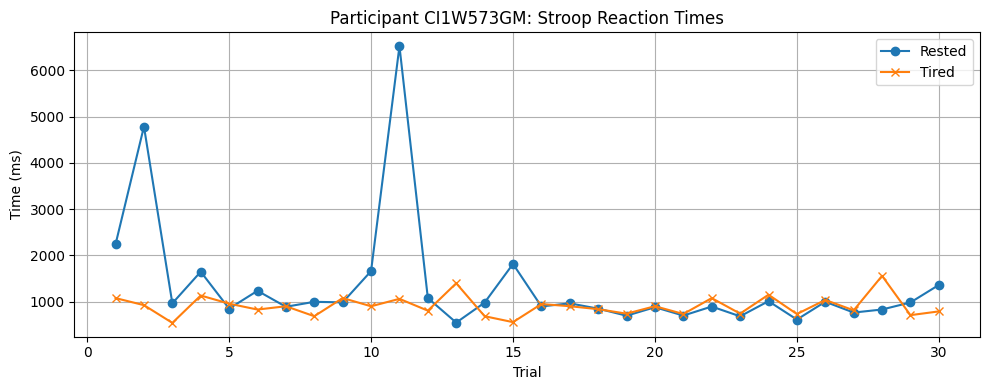

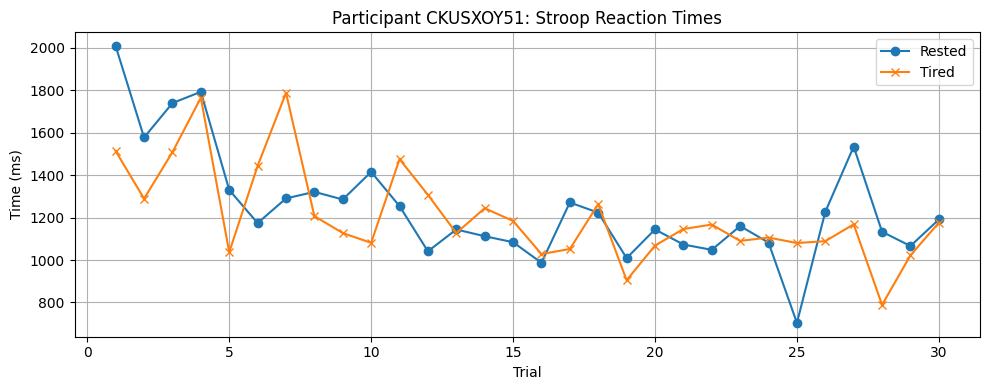

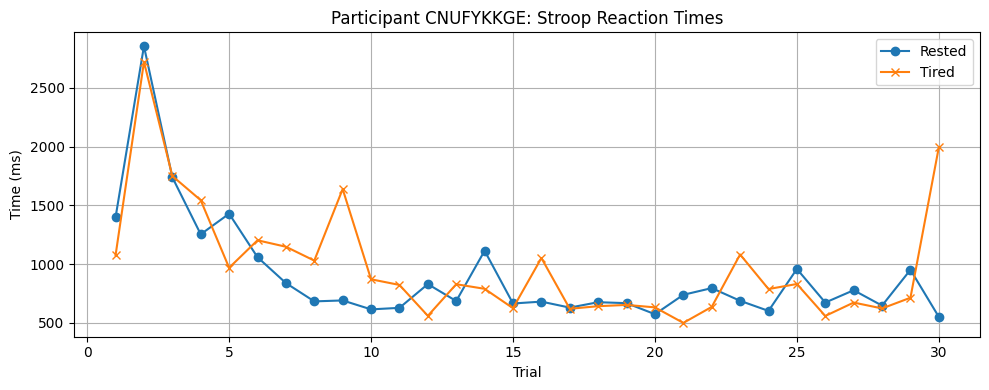

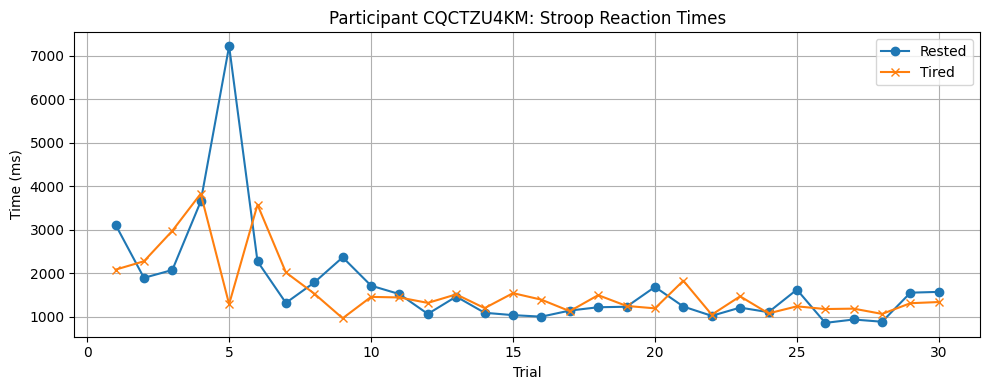

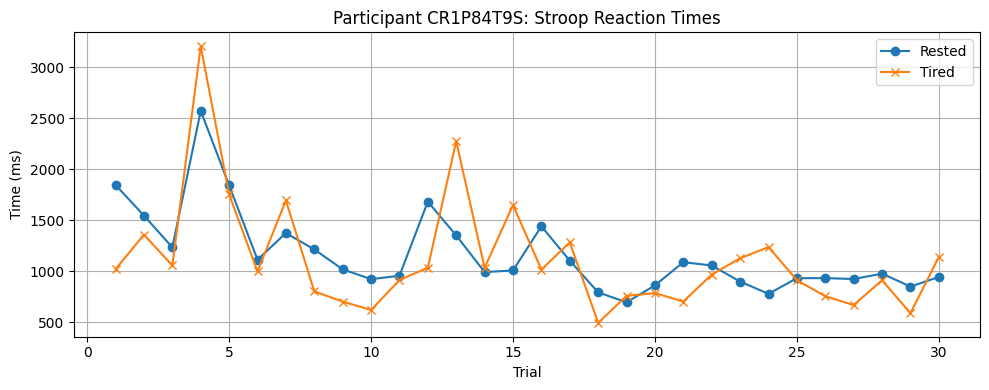

In [93]:
# Plot individual reaction times per trial
for participant in stroop_trials_df['participantCode'].unique():
    sub_df = stroop_trials_df[stroop_trials_df['participantCode'] == participant]
    plt.figure(figsize=(10, 4))
    plt.plot(sub_df['trial'], sub_df['rested_time'], label='Rested', marker='o')
    plt.plot(sub_df['trial'], sub_df['tired_time'], label='Tired', marker='x')
    plt.title(f"Participant {participant}: Stroop Reaction Times")
    plt.xlabel("Trial")
    plt.ylabel("Time (ms)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


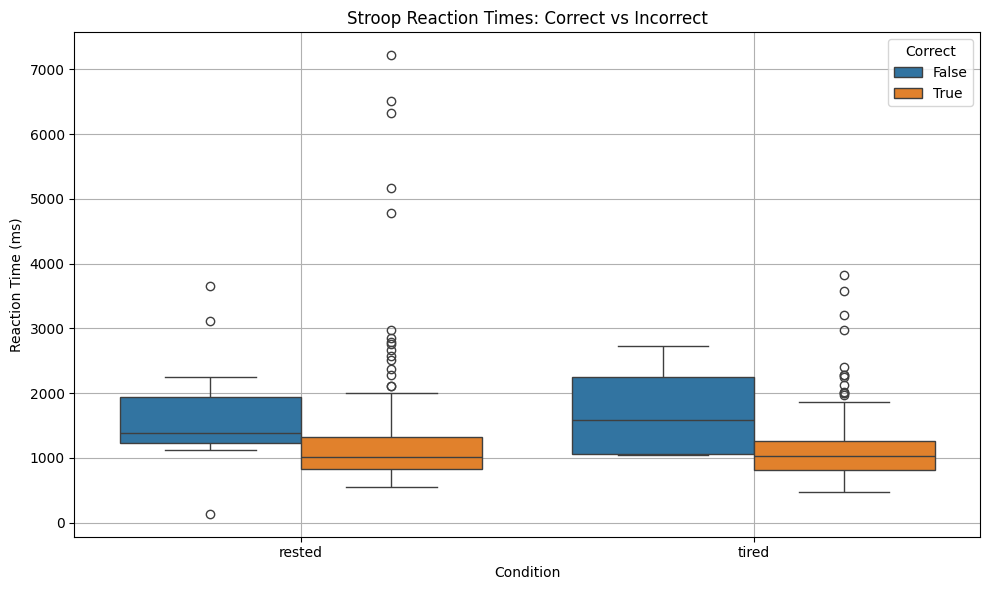

In [94]:
# Create melted dataframe with one row per state per trial
stroop_melted = pd.melt(
    stroop_trials_df,
    id_vars=["participantCode", "trial"],
    value_vars=["rested_time", "tired_time"],
    var_name="state",
    value_name="time_ms"
)

# Map correctness to the melted dataframe
stroop_melted["correct"] = pd.melt(
    stroop_trials_df[["rested_correct", "tired_correct"]],
    value_name="correct"
)["correct"]

# Label states cleanly
stroop_melted["state"] = stroop_melted["state"].str.replace("_time", "")

plt.figure(figsize=(10, 6))
sns.boxplot(data=stroop_melted, x="state", y="time_ms", hue="correct")
plt.title("Stroop Reaction Times: Correct vs Incorrect")
plt.ylabel("Reaction Time (ms)")
plt.xlabel("Condition")
plt.legend(title="Correct")
plt.grid(True)
plt.tight_layout()
plt.show()


In [95]:

# Separate groups
correct_times = stroop_melted[stroop_melted["correct"] == True]["time_ms"]
incorrect_times = stroop_melted[stroop_melted["correct"] == False]["time_ms"]

# Run t-test
t_stat, p_val = ttest_ind(correct_times, incorrect_times, equal_var=False)

print(f"T-test between correct and incorrect times:")
print(f"t = {t_stat:.2f}, p = {p_val:.4f}")


T-test between correct and incorrect times:
t = -2.81, p = 0.0110


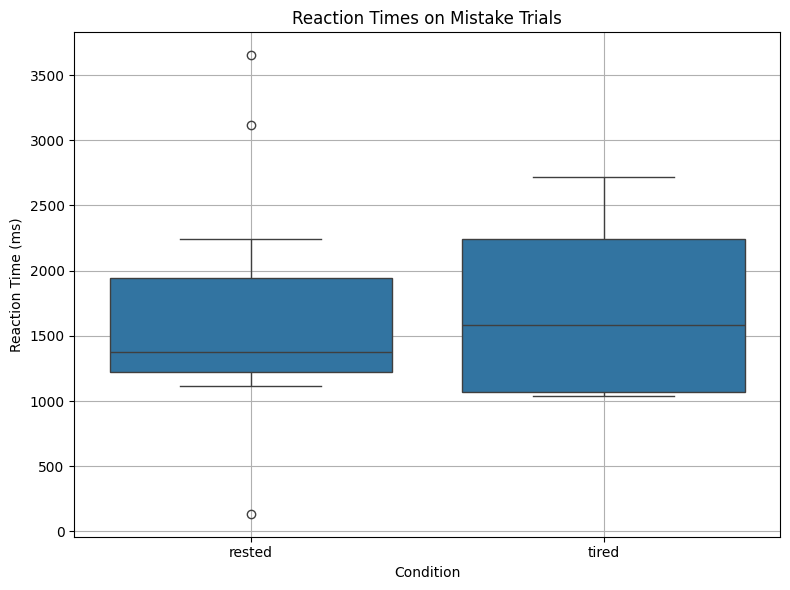

🔢 Total Mistake Counts:
Rested: 16
Tired: 4

📊 T-test on Mistake Reaction Times:
t = -0.18, p = 0.8623


In [96]:
# Filter to only mistake trials
mistake_trials = stroop_trials_df[(~stroop_trials_df['rested_correct']) | (~stroop_trials_df['tired_correct'])].copy()

# Reshape for easy plotting
mistake_times = pd.DataFrame({
    'participantCode': [],
    'state': [],
    'reaction_time': []
})

# Collect mistake trial data into a list first
mistake_records = []

for _, row in mistake_trials.iterrows():
    if not row['rested_correct']:
        mistake_records.append({
            'participantCode': row['participantCode'],
            'state': 'rested',
            'reaction_time': row['rested_time']
        })
    if not row['tired_correct']:
        mistake_records.append({
            'participantCode': row['participantCode'],
            'state': 'tired',
            'reaction_time': row['tired_time']
        })

# Convert to DataFrame once
mistake_times = pd.DataFrame(mistake_records)

plt.figure(figsize=(8, 6))
sns.boxplot(data=mistake_times, x='state', y='reaction_time')
plt.title("Reaction Times on Mistake Trials")
plt.ylabel("Reaction Time (ms)")
plt.xlabel("Condition")
plt.grid(True)
plt.tight_layout()
plt.show()

# Count total mistakes per condition
rested_mistake_count = (~stroop_trials_df['rested_correct']).sum()
tired_mistake_count = (~stroop_trials_df['tired_correct']).sum()

print("🔢 Total Mistake Counts:")
print(f"Rested: {rested_mistake_count}")
print(f"Tired: {tired_mistake_count}")

rested_times = mistake_times[mistake_times['state'] == 'rested']['reaction_time']
tired_times = mistake_times[mistake_times['state'] == 'tired']['reaction_time']

t_stat, p_val = ttest_ind(rested_times, tired_times, equal_var=False)
print(f"\n📊 T-test on Mistake Reaction Times:")
print(f"t = {t_stat:.2f}, p = {p_val:.4f}")


# Winsconsin

In [97]:
# Build Wisconsin trial-level dataframe from both conditions
def extract_wisconsin_trials(df, condition):
    all_trials = []
    for _, row in df.iterrows():
        for trial in row.get("winsconsin", []):
            trial = dict(trial)
            trial['participantCode'] = row['participantCode']
            trial['condition'] = condition
            all_trials.append(trial)
    return all_trials


rested_trials = extract_wisconsin_trials(rested_common, "rested")
tired_trials = extract_wisconsin_trials(tired1_common, "tired")

winsconsin_df = pd.DataFrame(rested_trials + tired_trials)

# Add a trial index per participant and condition
winsconsin_df['trialIndex'] = winsconsin_df.groupby(['participantCode', 'condition']).cumcount()

# Keep only trials with index >= 6
winsconsin_df = winsconsin_df[winsconsin_df['trialIndex'] >= 6].copy()


In [98]:
# Make sure timeMs is in integer form
def extract_time_ms(x):
    return int(x['$numberInt']) if isinstance(x, dict) else int(x)

winsconsin_df['timeMs'] = winsconsin_df['timeMs'].apply(extract_time_ms)


In [99]:
# errorType: None (correct), "expected", "unexpected"
winsconsin_df['trialType'] = winsconsin_df['errorType'].fillna('correct')



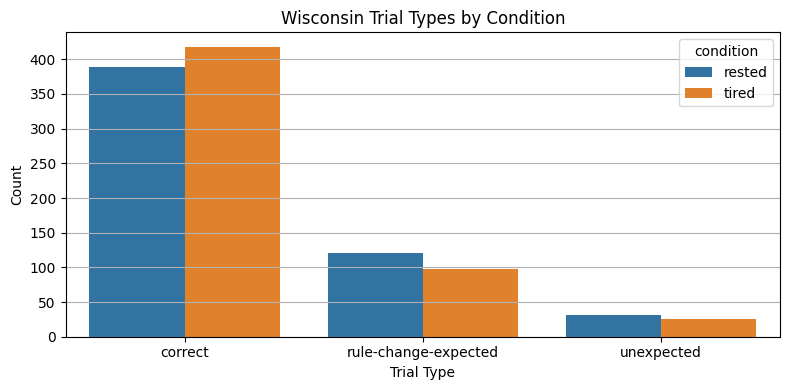

In [100]:
plt.figure(figsize=(8, 4))
sns.countplot(data=winsconsin_df, x='trialType', hue='condition')
plt.title("Wisconsin Trial Types by Condition")
plt.ylabel("Count")
plt.xlabel("Trial Type")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


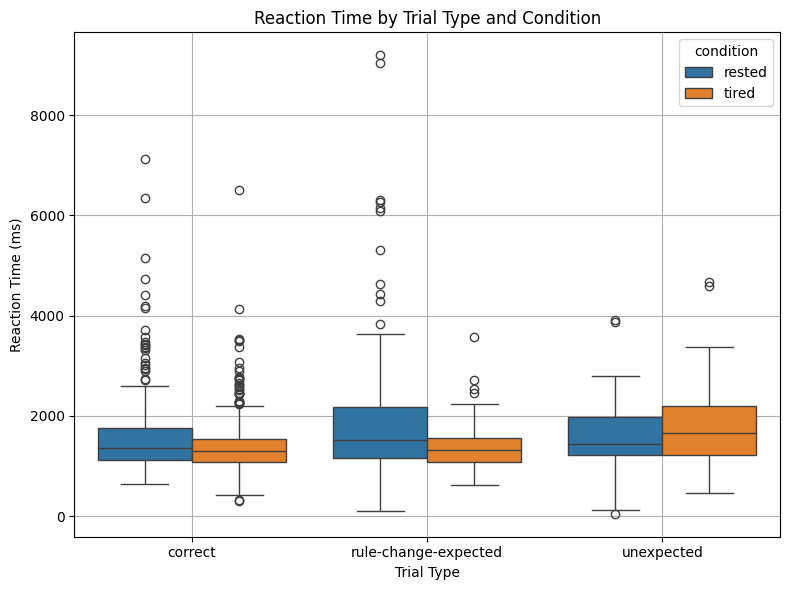

In [101]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=winsconsin_df, x='trialType', y='timeMs', hue='condition')
plt.title("Reaction Time by Trial Type and Condition")
plt.ylabel("Reaction Time (ms)")
plt.xlabel("Trial Type")
plt.grid(True)
plt.tight_layout()
plt.show()


In [102]:
# Recreate per-participant, per-condition summary table
summary = winsconsin_df.groupby(['participantCode', 'condition', 'trialType'])['timeMs'] \
    .agg(['count', 'mean']) \
    .unstack(fill_value=0)

# Flatten column names
summary.columns = ['_'.join(col).strip() for col in summary.columns.values]
summary.reset_index(inplace=True)

# Display in notebook

display(summary)



,participantCode,condition,count_correct,count_rule-change-expected,count_unexpected,mean_correct,mean_rule-change-expected,mean_unexpected
0,C03RMJ75X,rested,45,8,1,1579.066667,1832.875000,2034.000000
1,C03RMJ75X,tired,45,7,2,1386.733333,1367.428571,2647.000000
2,C2LP03LOS,rested,48,6,0,1417.833333,1201.166667,0.000000
3,C2LP03LOS,tired,44,8,2,1212.272727,1161.750000,1432.000000
4,C71FNNQ5L,rested,48,5,1,1493.750000,1143.400000,1656.000000
5,C71FNNQ5L,tired,46,7,1,1558.173913,1328.142857,1847.000000
6,C8DPGBOM9,rested,40,12,2,1312.875000,1740.666667,1233.000000
7,C8DPGBOM9,tired,43,8,3,1100.837209,1193.250000,1419.000000
8,C920D5GLC,rested,45,7,2,1392.600000,1935.000000,2804.000000
9,C920D5GLC,tired,49,5,0,1263.612245,1354.200000,0.000000


In [103]:

# Build mean reaction time per participant per condition and trial type
participant_means = winsconsin_df.groupby(['participantCode', 'condition', 'trialType'])['timeMs'].mean().unstack().reset_index()

# Separate into rested and tired
rested_means = participant_means[participant_means['condition'] == 'rested'].set_index('participantCode')
tired_means = participant_means[participant_means['condition'] == 'tired'].set_index('participantCode')

# Align and filter only common participants (should already be aligned)
common_participants = rested_means.index.intersection(tired_means.index)

# Function to run paired t-test between rested and tired for a given trialType
def compare_condition(trial_type):
    r = rested_means.loc[common_participants][trial_type]
    t = tired_means.loc[common_participants][trial_type]
    t_stat, p_val = ttest_rel(r, t)
    return pd.Series({'t': t_stat, 'p': p_val})

# Run tests
results_by_trial_type = pd.DataFrame({
    trial_type: compare_condition(trial_type)
    for trial_type in ['correct', 'rule-change-expected', 'unexpected']
}).T

print("Paired t-tests: Rested vs Tired per Trial Type")
display(results_by_trial_type)


Paired t-tests: Rested vs Tired per Trial Type


,t,p
correct,2.496158,0.034076
rule-change-expected,2.002232,0.076278
unexpected,NaN,NaN


In [104]:
# Function to compare trial types within each condition
def compare_types_within_condition(condition, type_a, type_b):
    sub_df = winsconsin_df[winsconsin_df['condition'] == condition]
    grouped = sub_df.groupby(['participantCode', 'trialType'])['timeMs'].mean().unstack()
    grouped = grouped.dropna(subset=[type_a, type_b])
    a = grouped[type_a]
    b = grouped[type_b]
    t_stat, p_val = ttest_rel(a, b)
    return pd.Series({'t': t_stat, 'p': p_val})

# Run for both conditions
results_within = pd.DataFrame({
    'rested_correct_vs_expected': compare_types_within_condition('rested', 'correct', 'rule-change-expected'),
    'rested_correct_vs_unexpected': compare_types_within_condition('rested', 'correct', 'unexpected'),
    'tired_correct_vs_expected': compare_types_within_condition('tired', 'correct', 'rule-change-expected'),
    'tired_correct_vs_unexpected': compare_types_within_condition('tired', 'correct', 'unexpected'),
}).T

print("\nPaired t-tests: Correct vs Mistake Within Each Condition")
display(results_within)



Paired t-tests: Correct vs Mistake Within Each Condition


,t,p
rested_correct_vs_expected,-1.048966,0.321544
rested_correct_vs_unexpected,-0.790337,0.452120
tired_correct_vs_expected,-0.204710,0.842353
tired_correct_vs_unexpected,-2.497807,0.037068


In [105]:
winsconsin_df['trialType'] = winsconsin_df['errorType'].fillna('correct')
# Group by trial number, condition, and trial type
trial_stats = winsconsin_df.groupby(['trialIndex', 'condition', 'trialType']).agg(
    mean_time=('timeMs', 'mean'),
    count=('timeMs', 'count')
).reset_index()


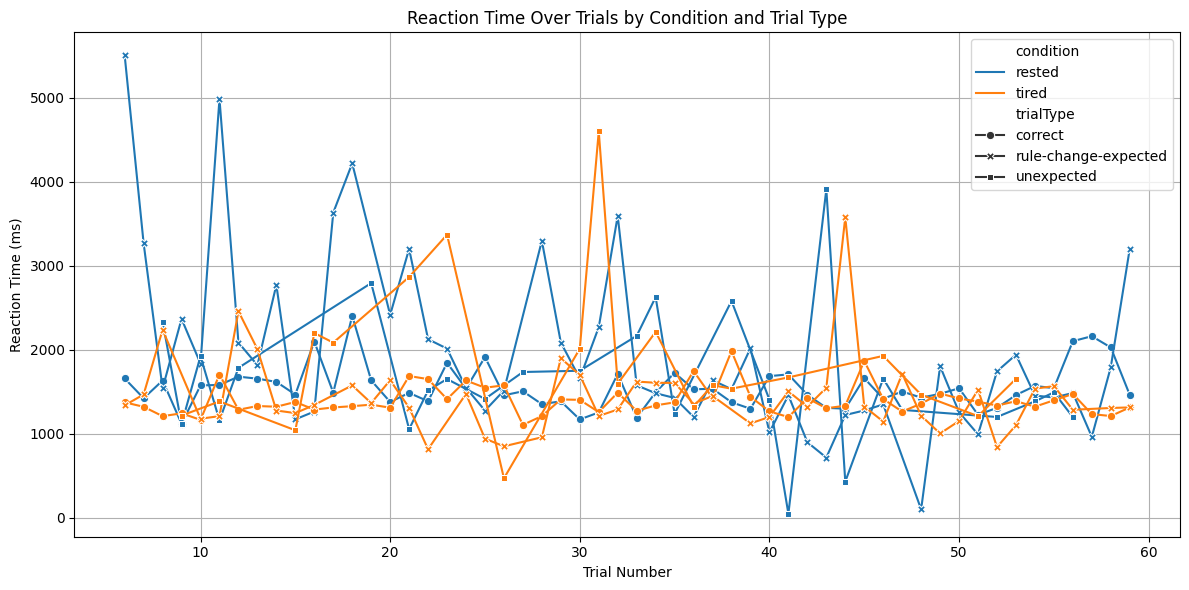

In [106]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=trial_stats,
    x='trialIndex',
    y='mean_time',
    hue='condition',
    style='trialType',
    markers=True,
    dashes=False
)
plt.title("Reaction Time Over Trials by Condition and Trial Type")
plt.ylabel("Reaction Time (ms)")
plt.xlabel("Trial Number")
plt.grid(True)
plt.tight_layout()
plt.show()


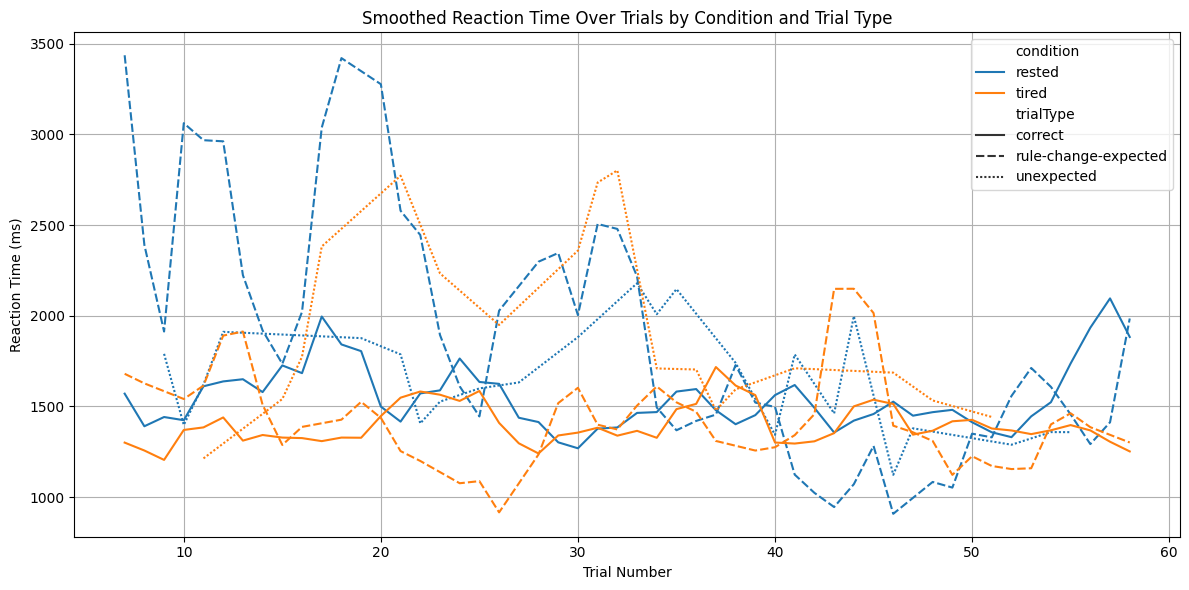

In [107]:
# Add 3-trial rolling mean for smoother trends
trial_stats['mean_time_smooth'] = (
    trial_stats
    .groupby(['condition', 'trialType'])['mean_time']
    .transform(lambda x: x.rolling(3, center=True).mean())
)

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=trial_stats,
    x='trialIndex',
    y='mean_time_smooth',
    hue='condition',
    style='trialType'
)
plt.title("Smoothed Reaction Time Over Trials by Condition and Trial Type")
plt.ylabel("Reaction Time (ms)")
plt.xlabel("Trial Number")
plt.grid(True)
plt.tight_layout()
plt.show()


In [108]:

# Create a clean df for modeling
model_df = winsconsin_df[['trialIndex', 'condition', 'trialType', 'timeMs']].dropna()

# Function to fit linear model per group
def fit_slope(group):
    model = smf.ols('timeMs ~ trialIndex', data=group).fit()
    return pd.Series({
        'slope': model.params['trialIndex'],
        'p_value': model.pvalues['trialIndex'],
        'r_squared': model.rsquared
    })

# Run regression per condition and trialType
slopes = (
    model_df
    .groupby(['condition', 'trialType'])
    .apply(fit_slope)
    .reset_index()
)

print("Reaction Time Trends Over Trials")
display(slopes)


Reaction Time Trends Over Trials


/var/folders/v_/rx6dzypn6sxgjcqrs3v3nkhm0000gn/T/ipykernel_99436/4020672519.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(fit_slope)


,condition,trialType,slope,p_value,r_squared
0,rested,correct,-0.569271,0.813591,0.000144
1,rested,rule-change-expected,-29.050753,0.000489,0.098294
2,rested,unexpected,-7.158619,0.511374,0.015015
3,tired,correct,0.493104,0.770967,0.000204
4,tired,rule-change-expected,-1.059667,0.752216,0.001054
5,tired,unexpected,-9.091153,0.591704,0.012701


# London

In [109]:
min_moves_per_puzzle = {
    0: 31,
    1: 25,
    2: 31,
    3: 16,
    4: None,
    5: None,
}

def extract_tower_trials(df, condition):
    all_trials = []
    for _, row in df.iterrows():
        for trial in row.get("towerOfLondon", []):
            puzzle_id = int(trial['puzzle'])
            moves = int(trial['moves'])
            time_ms = int(trial['timeMs'])
            min_moves = min_moves_per_puzzle.get(puzzle_id, None)
            if min_moves is None:
                continue  # skip unknown puzzles
            all_trials.append({
                'participantCode': row['participantCode'],
                'condition': condition,
                'puzzle': puzzle_id,
                'moves': moves,
                'timeMs': time_ms,
                'min_moves': min_moves,
                'extra_moves': moves - min_moves
            })
    return all_trials

rested_trials = extract_tower_trials(rested_common, "rested")
tired_trials = extract_tower_trials(tired1_common, "tired")

tower_df = pd.DataFrame(rested_trials + tired_trials)


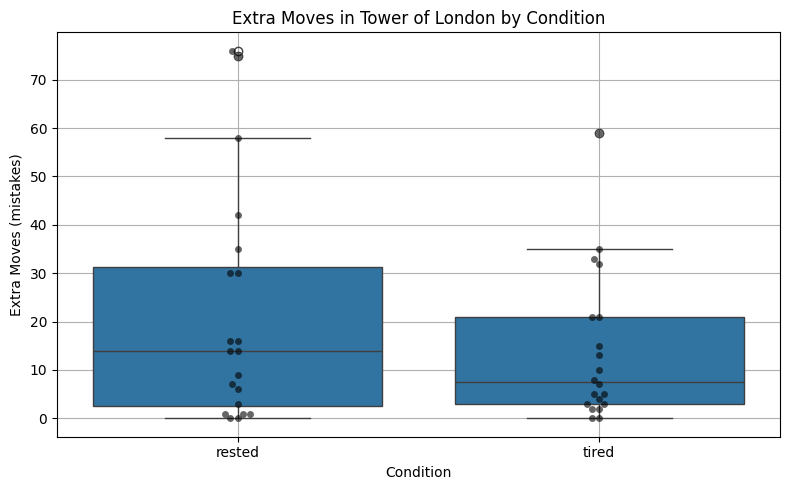

In [110]:

plt.figure(figsize=(8, 5))
sns.boxplot(data=tower_df, x='condition', y='extra_moves')
sns.swarmplot(data=tower_df, x='condition', y='extra_moves', color='black', alpha=0.6)
plt.title("Extra Moves in Tower of London by Condition")
plt.ylabel("Extra Moves (mistakes)")
plt.xlabel("Condition")
plt.grid(True)
plt.tight_layout()
plt.show()


In [111]:

# Compute mean extra moves per participant per condition
summary = tower_df.groupby(['participantCode', 'condition'])['extra_moves'].mean().unstack()

# Drop missing data (e.g. someone missing a tired test)
summary = summary.dropna()

# Paired t-test
t_stat, p_val = ttest_rel(summary['rested'], summary['tired'])

print(f"Paired t-test on extra moves:")
print(f"t = {t_stat:.4f}, p = {p_val:.4f}")


Paired t-test on extra moves:
t = 1.1823, p = 0.2674


# Chess

In [112]:

engine_path = "/opt/homebrew/bin/stockfish"
engine = chess.engine.SimpleEngine.popen_uci(engine_path)

def extract_score(info, white_pov=True):
    score = info["score"].white() if white_pov else info["score"].black()
    if score.is_mate():
        mate_in = score.mate()
        return 10000 if mate_in > 0 else -10000
    return score.score()

def evaluate_move_sequence(moves):
    board = chess.Board()
    evals = []

    for move in moves:
        if board.is_game_over():
            break

        try:
            move_san = move["san"]
            move_color = move["color"]

            if move_color == "w":
                # Evaluate before White's move — from White's POV
                info_before = engine.analyse(board, chess.engine.Limit(depth=15))
                eval_before = extract_score(info_before, white_pov=True)

                board.push_san(move_san)  # White makes the move

                # Evaluate after White's move — still from White's POV
                info_after = engine.analyse(board, chess.engine.Limit(depth=15))
                eval_after = extract_score(info_after, white_pov=True)

                cp_delta = eval_before - eval_after  # always from White's perspective

                evals.append({
                    "move": move_san,
                    "eval_before": eval_before,
                    "eval_after": eval_after,
                    "cp_delta": cp_delta,
                    "color": move_color
                })
            else:
                # Push Black move, but don't evaluate
                board.push_san(move_san)

        except Exception as e:
            evals.append({
                "move": move.get("san", "?"),
                "eval_before": None,
                "eval_after": None,
                "cp_delta": None,
                "color": move.get("color", "?"),
                "error": str(e)
            })

    return evals



# df = rested_common or tired1_common
def evaluate_all_games(df, state_label):
    records = []
    for _, row in df.iterrows():
        participant = row["participantCode"]
        for game in row["chess"]:
            game_id = game["game"]
            difficulty = game["difficulty"]
            moves = game["moves"]
            evaluated_moves = evaluate_move_sequence(moves)

            for i, em in enumerate(evaluated_moves):
                em.update({
                    "participantCode": participant,
                    "game_id": game_id,
                    "difficulty": difficulty,
                    "move_number": i + 1,
                    "state": state_label
                })
                records.append(em)

    return records


In [113]:
rested_eval = evaluate_all_games(rested_common, "rested")
tired1_eval = evaluate_all_games(tired1_common, "tired1")

eval_df = pd.DataFrame(rested_eval + tired1_eval)


In [114]:
eval_df

,move,eval_before,eval_after,cp_delta,color,participantCode,game_id,difficulty,move_number,state
0,g4,39,-146,185,w,C03RMJ75X,1,0,1,rested
1,f3,-66,-10000,9934,w,C03RMJ75X,1,0,2,rested
2,Nh3,31,-56,87,w,C03RMJ75X,2,0,1,rested
3,Nc3,1,-35,36,w,C03RMJ75X,2,0,2,rested
4,d4,7,0,7,w,C03RMJ75X,2,0,3,rested
...,...,...,...,...,...,...,...,...,...,...
1675,Ke2,-1068,-1109,41,w,CR1P84T9S,3,0,28,tired1
1676,Kf2,-959,-977,18,w,CR1P84T9S,3,0,29,tired1
1677,Rxa1,-1001,-1007,6,w,CR1P84T9S,3,0,30,tired1
1678,Rd1,-962,-10000,9038,w,CR1P84T9S,3,0,31,tired1


In [115]:
# Only white moves
white_moves = eval_df[eval_df["color"] == "w"]

# Group by participant, game, difficulty, and state
grouped = white_moves.groupby(["participantCode", "game_id", "difficulty", "state"])

# Compute move quality metrics
summary_df = grouped.agg(
    avg_cp_delta=("cp_delta", "mean"),
    median_cp_delta=("cp_delta", "median"),
    blunder_rate=("cp_delta", lambda x: (x > 300).mean()),
    move_count=("cp_delta", "count")
).reset_index()


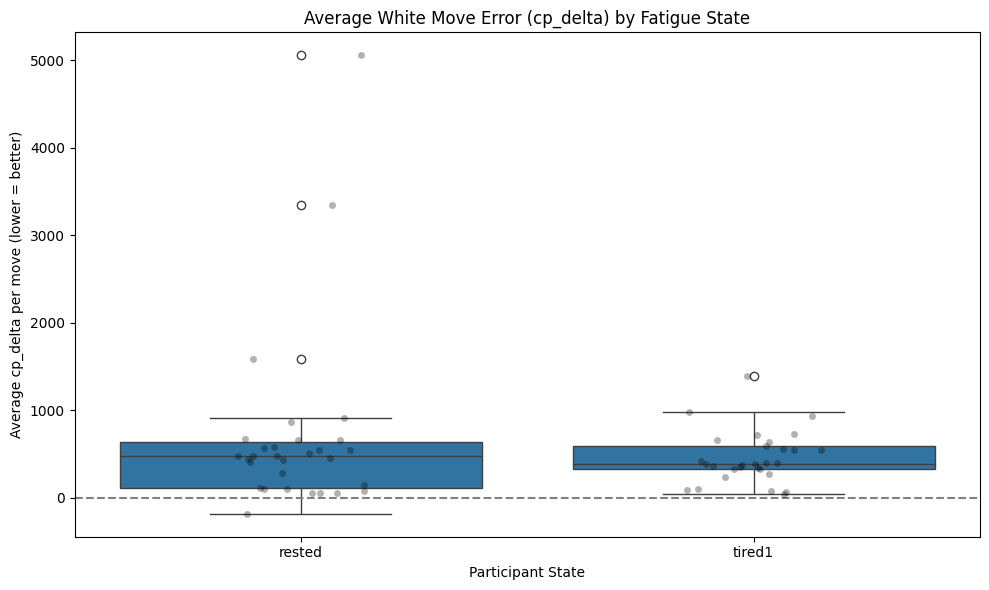

In [116]:

plt.figure(figsize=(10, 6))
sns.boxplot(data=summary_df, x="state", y="avg_cp_delta")
sns.stripplot(data=summary_df, x="state", y="avg_cp_delta", color="black", alpha=0.3, jitter=0.15)

plt.title("Average White Move Error (cp_delta) by Fatigue State")
plt.ylabel("Average cp_delta per move (lower = better)")
plt.xlabel("Participant State")
plt.axhline(0, linestyle="--", color="gray")
plt.tight_layout()
plt.show()


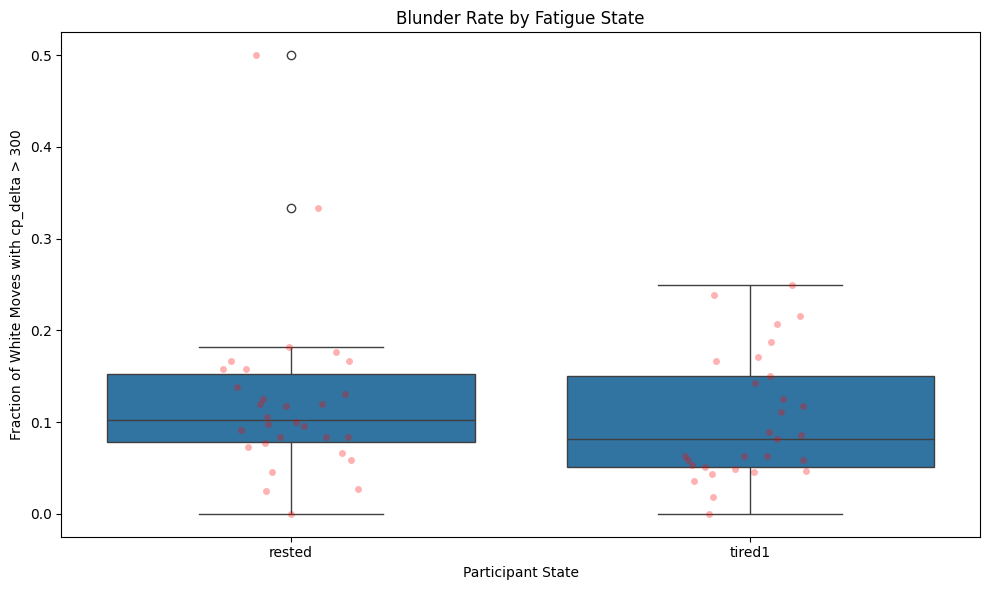

In [117]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=summary_df, x="state", y="blunder_rate")
sns.stripplot(data=summary_df, x="state", y="blunder_rate", color="red", alpha=0.3, jitter=0.15)

plt.title("Blunder Rate by Fatigue State")
plt.ylabel("Fraction of White Moves with cp_delta > 300")
plt.xlabel("Participant State")
plt.tight_layout()
plt.show()


In [118]:

# Pivot summary_df to get paired values per participant
summary_paired = summary_df.pivot_table(
    index="participantCode",
    columns="state",
    values=["avg_cp_delta", "blunder_rate"]
).dropna()

# Run Wilcoxon test for blunder rate
print("=== Blunder Rate Comparison (Wilcoxon signed-rank) ===")
stat, p = wilcoxon(
    summary_paired["blunder_rate"]["rested"],
    summary_paired["blunder_rate"]["tired1"]
)
print("Wilcoxon result: stat =", stat, ", p =", p)

# Run Wilcoxon test for average cp_delta
print("\n=== Average cp_delta Comparison (Wilcoxon signed-rank) ===")
stat, p = wilcoxon(
    summary_paired["avg_cp_delta"]["rested"],
    summary_paired["avg_cp_delta"]["tired1"]
)
print("Wilcoxon result: stat =", stat, ", p =", p)


=== Blunder Rate Comparison (Wilcoxon signed-rank) ===
Wilcoxon result: stat = 17.0 , p = 0.322265625

=== Average cp_delta Comparison (Wilcoxon signed-rank) ===
Wilcoxon result: stat = 20.0 , p = 0.4921875


In [119]:
def classify_move(cp_delta):
    if cp_delta is None:
        return "unknown"
    elif cp_delta > 300:
        return "blunder"
    elif cp_delta > 50:
        return "inaccuracy"
    else:
        return "good"

eval_df["move_type"] = eval_df["cp_delta"].apply(classify_move)


In [120]:
move_type_counts = (
    eval_df[eval_df["color"] == "w"]
    .groupby(["state", "move_type"])
    .size()
    .reset_index(name="count")
)

# Convert to percent within each state
total_by_state = move_type_counts.groupby("state")["count"].transform("sum")
move_type_counts["percent"] = move_type_counts["count"] / total_by_state * 100


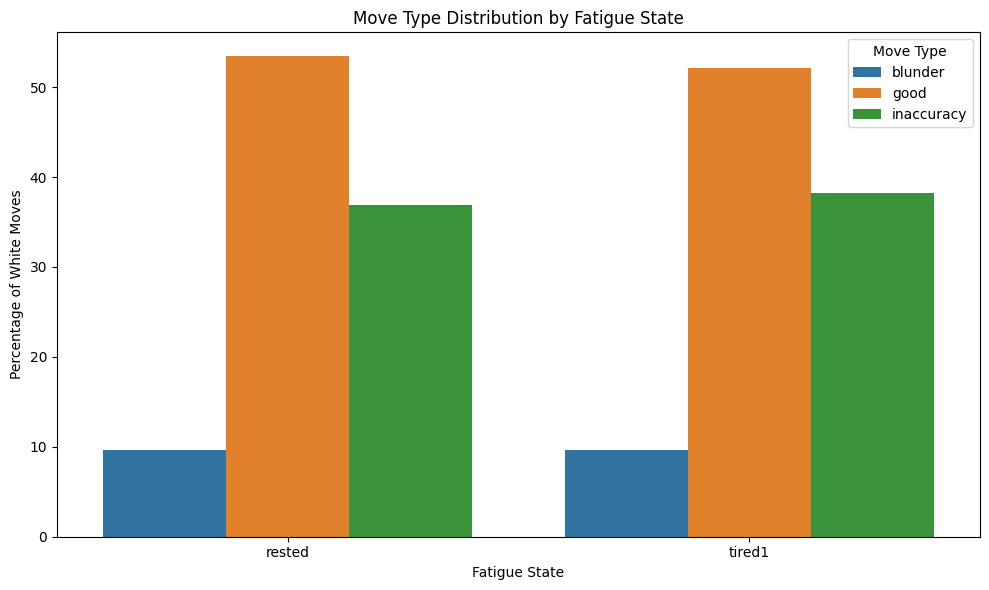

In [121]:

plt.figure(figsize=(10, 6))
sns.barplot(data=move_type_counts, x="state", y="percent", hue="move_type")

plt.title("Move Type Distribution by Fatigue State")
plt.ylabel("Percentage of White Moves")
plt.xlabel("Fatigue State")
plt.legend(title="Move Type")
plt.tight_layout()
plt.show()


In [122]:
# Only white moves from game 3
game3_moves = eval_df[
    (eval_df["color"] == "w") & 
    (eval_df["game_id"] == 3)
].copy()

game3_moves["move_type"] = game3_moves["cp_delta"].apply(classify_move)


In [123]:
game3_counts = (
    game3_moves
    .groupby(["state", "move_type"])
    .size()
    .reset_index(name="count")
)

# Normalize to percentage within each state
total_by_state = game3_counts.groupby("state")["count"].transform("sum")
game3_counts["percent"] = game3_counts["count"] / total_by_state * 100


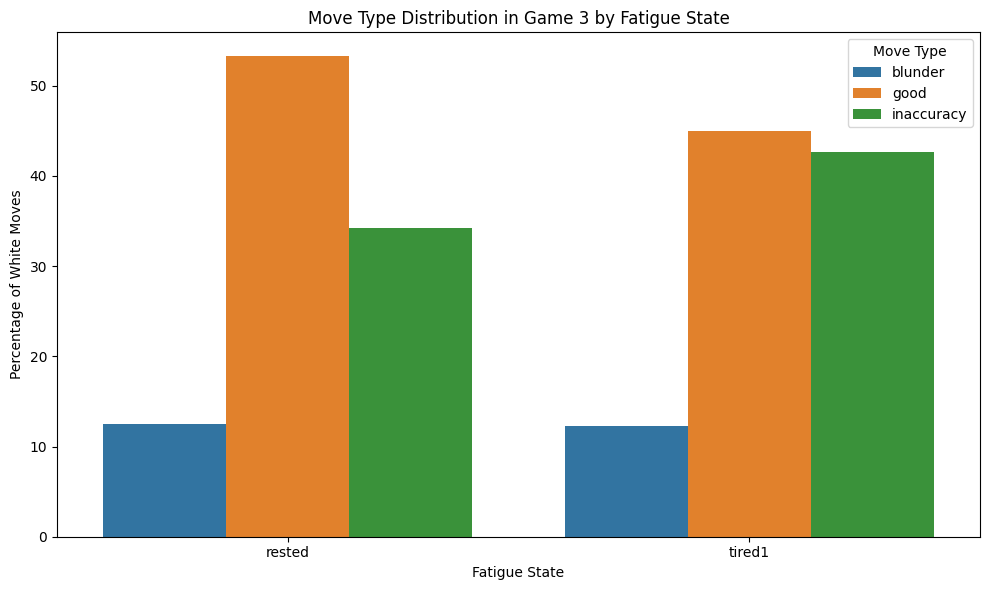

In [124]:

plt.figure(figsize=(10, 6))
sns.barplot(data=game3_counts, x="state", y="percent", hue="move_type")

plt.title("Move Type Distribution in Game 3 by Fatigue State")
plt.ylabel("Percentage of White Moves")
plt.xlabel("Fatigue State")
plt.legend(title="Move Type")
plt.tight_layout()
plt.show()


In [125]:


# Step 1: Filter white, non-checkmate, Game 3 moves
game3_clean = eval_df[
    (eval_df["color"] == "w") &
    (eval_df["game_id"] == 3) &
    (eval_df["eval_after"].abs() != 10000)
].copy()

# Step 2: Aggregate for plotting and stats
summary_game3_long = (
    game3_clean.groupby(["participantCode", "state"])
    .agg(
        avg_cp_delta=("cp_delta", "mean"),
        blunder_rate=("cp_delta", lambda x: (x > 300).mean()),
        move_count=("cp_delta", "count")
    )
    .reset_index()
)

# Step 3: Prepare wide format for Wilcoxon
summary_game3_wide = summary_game3_long.pivot(index="participantCode", columns="state")
summary_game3_wide = summary_game3_wide.dropna()  # keep only full pairs

# Step 4: Wilcoxon tests
print("=== Game 3: Blunder Rate Comparison (Wilcoxon signed-rank) ===")
stat, p = wilcoxon(
    summary_game3_wide["blunder_rate"]["rested"],
    summary_game3_wide["blunder_rate"]["tired1"]
)
print("Wilcoxon result: stat =", stat, ", p =", p)

print("\n=== Game 3: Average cp_delta Comparison (Wilcoxon signed-rank) ===")
stat, p = wilcoxon(
    summary_game3_wide["avg_cp_delta"]["rested"],
    summary_game3_wide["avg_cp_delta"]["tired1"]
)
print("Wilcoxon result: stat =", stat, ", p =", p)

=== Game 3: Blunder Rate Comparison (Wilcoxon signed-rank) ===
Wilcoxon result: stat = 21.0 , p = 0.87890625

=== Game 3: Average cp_delta Comparison (Wilcoxon signed-rank) ===
Wilcoxon result: stat = 22.0 , p = 1.0


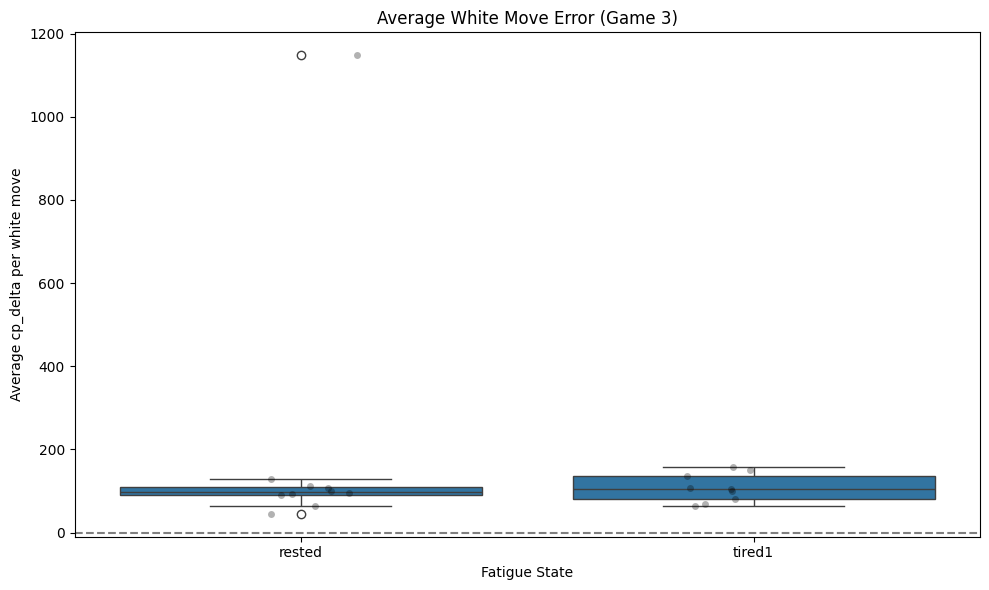

In [126]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=summary_game3_long, x="state", y="avg_cp_delta")
sns.stripplot(data=summary_game3_long, x="state", y="avg_cp_delta", color="black", alpha=0.3, jitter=0.15)

plt.title("Average White Move Error (Game 3)")
plt.ylabel("Average cp_delta per white move")
plt.xlabel("Fatigue State")
plt.axhline(0, linestyle="--", color="gray")
plt.tight_layout()
plt.show()

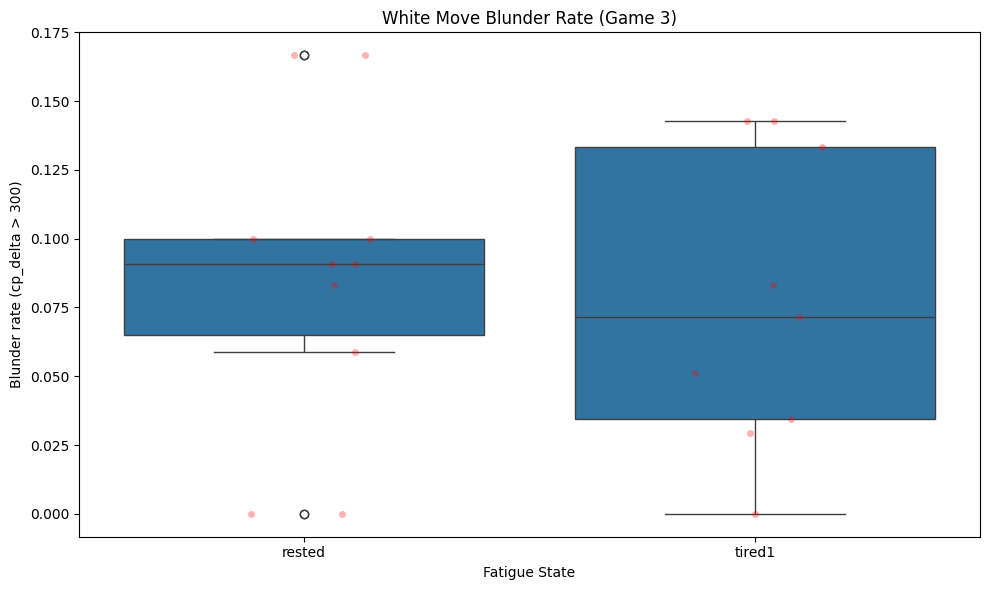

In [127]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=summary_game3_long, x="state", y="blunder_rate")
sns.stripplot(data=summary_game3_long, x="state", y="blunder_rate", color="red", alpha=0.3, jitter=0.15)

plt.title("White Move Blunder Rate (Game 3)")
plt.ylabel("Blunder rate (cp_delta > 300)")
plt.xlabel("Fatigue State")
plt.tight_layout()
plt.show()


In [128]:
eval_clean = eval_df[
    (eval_df["color"] == "w") &
    (eval_df["eval_after"].abs() != 10000)
].copy()

summary_all_clean = (
    eval_clean.groupby(["participantCode", "state", "difficulty"])
    .agg(
        avg_cp_delta=("cp_delta", "mean"),
        blunder_rate=("cp_delta", lambda x: (x > 300).mean()),
        move_count=("cp_delta", "count")
    )
    .reset_index()
)

game3_clean = eval_clean[eval_clean["game_id"] == 3]

summary_game3_clean = (
    game3_clean.groupby(["participantCode", "state", "difficulty"])
    .agg(
        avg_cp_delta=("cp_delta", "mean"),
        blunder_rate=("cp_delta", lambda x: (x > 300).mean()),
        move_count=("cp_delta", "count")
    )
    .reset_index()
)


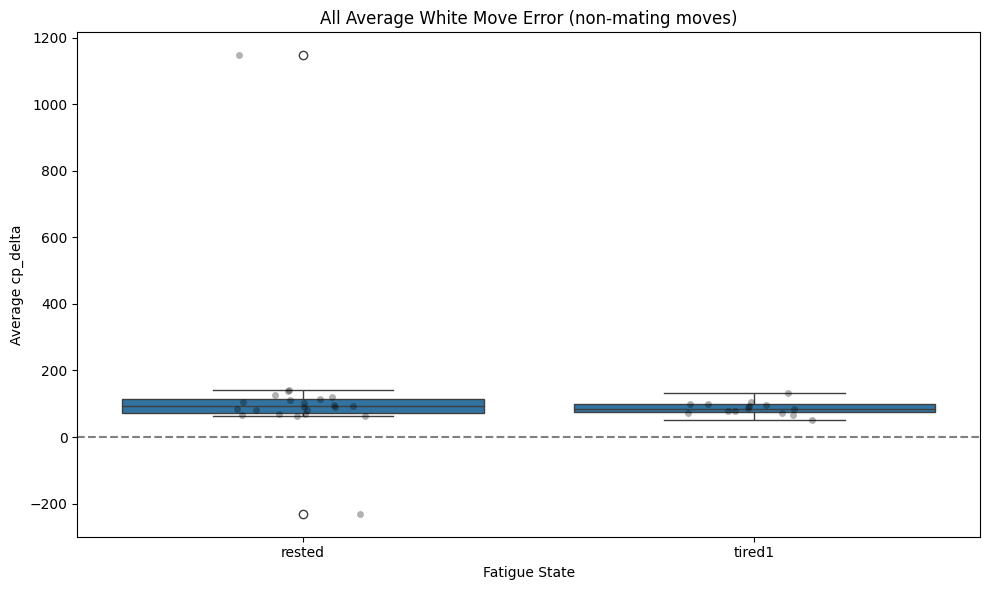

In [129]:

plt.figure(figsize=(10, 6))
sns.boxplot(data=summary_all_clean, x="state", y="avg_cp_delta")
sns.stripplot(data=summary_all_clean, x="state", y="avg_cp_delta", color="black", alpha=0.3, jitter=0.15)
plt.title("All Average White Move Error (non-mating moves)")
plt.ylabel("Average cp_delta")
plt.xlabel("Fatigue State")
plt.axhline(0, linestyle="--", color="gray")
plt.tight_layout()
plt.show()


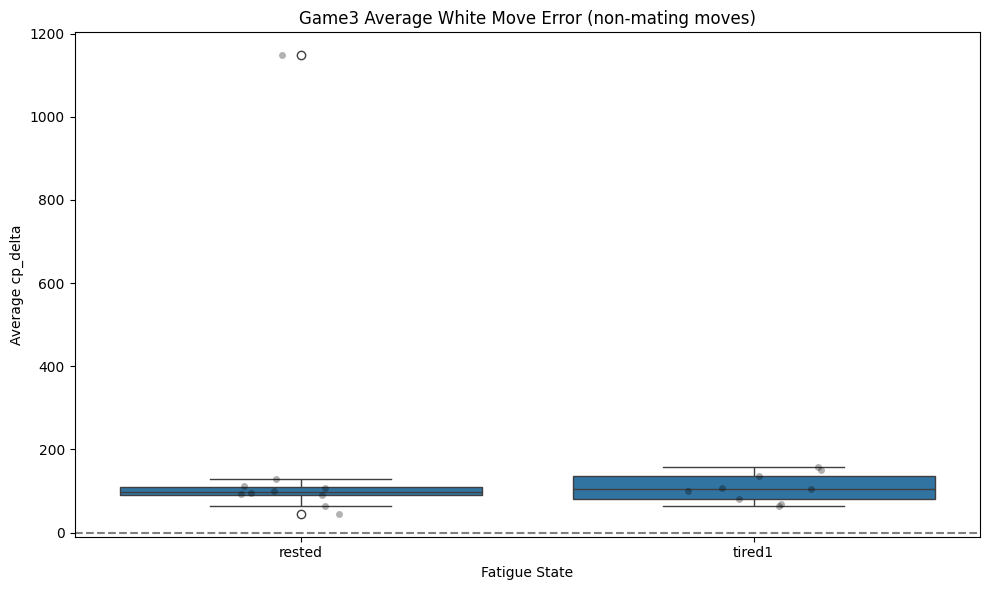

In [130]:

plt.figure(figsize=(10, 6))
sns.boxplot(data=summary_game3_clean, x="state", y="avg_cp_delta")
sns.stripplot(data=summary_game3_clean, x="state", y="avg_cp_delta", color="black", alpha=0.3, jitter=0.15)
plt.title("Game3 Average White Move Error (non-mating moves)")
plt.ylabel("Average cp_delta")
plt.xlabel("Fatigue State")
plt.axhline(0, linestyle="--", color="gray")
plt.tight_layout()
plt.show()


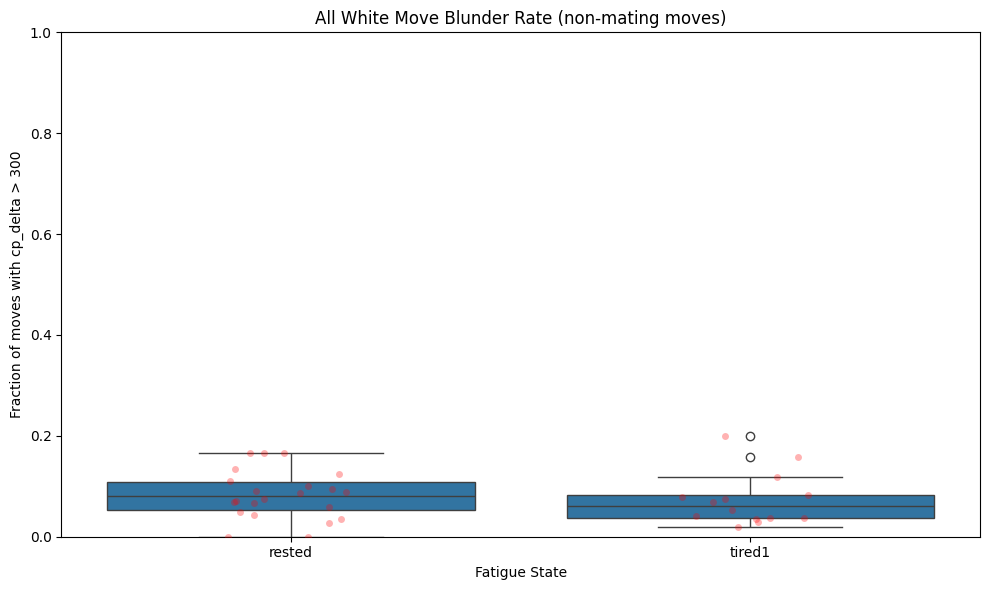

In [131]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=summary_all_clean, x="state", y="blunder_rate")
sns.stripplot(data=summary_all_clean, x="state", y="blunder_rate", color="red", alpha=0.3, jitter=0.15)
plt.title("All White Move Blunder Rate (non-mating moves)")
plt.ylabel("Fraction of moves with cp_delta > 300")
plt.xlabel("Fatigue State")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


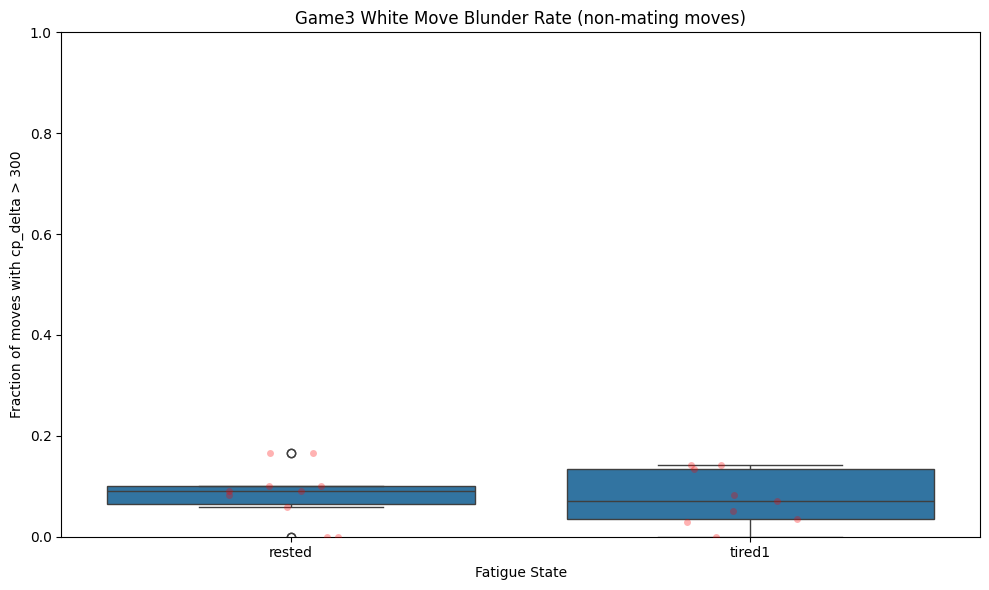

In [132]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=summary_game3_clean, x="state", y="blunder_rate")
sns.stripplot(data=summary_game3_clean, x="state", y="blunder_rate", color="red", alpha=0.3, jitter=0.15)
plt.title("Game3 White Move Blunder Rate (non-mating moves)")
plt.ylabel("Fraction of moves with cp_delta > 300")
plt.xlabel("Fatigue State")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


# Survey

In [133]:
# Map codes to readable labels
difficulty_map = {
    "q5o1": "Too easy", "q5o2": "Just right", "q5o3": "Too hard"
}
satisfaction_map = {
    "q8o1": "Very unsatisfying", "q8o2": "Unsatisfying", "q8o3": "Neutral",
    "q8o4": "Satisfying", "q8o5": "Very satisfying"
}

# Function to parse survey block
def extract_chess_survey_data(df, state_label):
    records = []
    for _, row in df.iterrows():
        participant = row["participantCode"]
        survey = row.get("survey", {})
        games = row.get("chess", [])
        
        # Build a map of game number → actual difficulty
        difficulty_lookup = {game["game"]: game["difficulty"] for game in games if "game" in game and "difficulty" in game}
        
        for game_index in range(3):
            q_diff = f"q{5 + game_index}"
            q_sat = f"q{8 + game_index}"
            perceived_diff = difficulty_map.get(survey.get(q_diff, ""), "Unknown")
            satisfaction = satisfaction_map.get(survey.get(q_sat, ""), "Unknown")
            actual_diff = difficulty_lookup.get(game_index + 1, "Unknown")

            records.append({
                "participantCode": participant,
                "game": game_index + 1,
                "perceived_difficulty": perceived_diff,
                "actual_difficulty": actual_diff,
                "satisfaction": satisfaction,
                "state": state_label
            })
    return pd.DataFrame(records)

# Apply to both states
rested_survey_df = extract_chess_survey_data(rested_common, "rested")
tired_survey_df = extract_chess_survey_data(tired1_common, "tired1")

# Combine
combined_survey_df = pd.concat([rested_survey_df, tired_survey_df], ignore_index=True)
combined_survey_df["difficulty_match"] = (
    combined_survey_df["actual_difficulty"].astype(str).str.lower() ==
    combined_survey_df["perceived_difficulty"].astype(str).str.lower()
)
combined_survey_df.sort_values(by=["participantCode", "state", "game"], inplace=True)

In [134]:
print("Actual difficulty values:", combined_survey_df["actual_difficulty"].unique())
print("Perceived difficulty values:", combined_survey_df["perceived_difficulty"].unique())


Actual difficulty values: [ 0  2  5  3  1 10 18  4]
Perceived difficulty values: ['Too hard' 'Just right' 'Too easy']


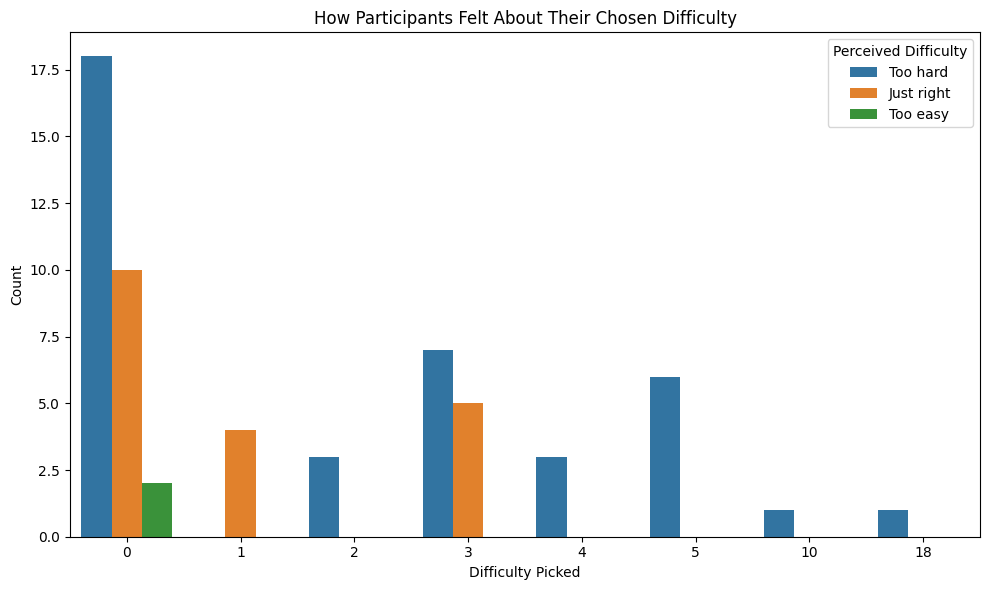

In [135]:
plt.figure(figsize=(10, 6))
sns.countplot(
    data=combined_survey_df,
    x="actual_difficulty",
    hue="perceived_difficulty",
    order=sorted(combined_survey_df["actual_difficulty"].unique())
)
plt.title("How Participants Felt About Their Chosen Difficulty")
plt.xlabel("Difficulty Picked")
plt.ylabel("Count")
plt.legend(title="Perceived Difficulty")
plt.tight_layout()
plt.show()


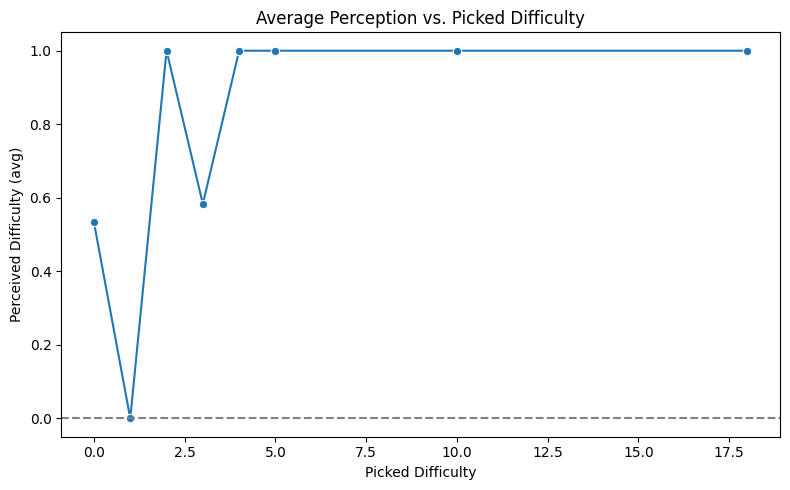

In [136]:
perception_score = {
    "Too easy": -1,
    "Just right": 0,
    "Too hard": 1
}
combined_survey_df["perceived_score"] = combined_survey_df["perceived_difficulty"].map(perception_score)

avg_perception = (
    combined_survey_df.groupby("actual_difficulty")["perceived_score"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(8, 5))
sns.lineplot(data=avg_perception, x="actual_difficulty", y="perceived_score", marker="o")
plt.axhline(0, color="gray", linestyle="--")
plt.title("Average Perception vs. Picked Difficulty")
plt.xlabel("Picked Difficulty")
plt.ylabel("Perceived Difficulty (avg)")
plt.tight_layout()
plt.show()


In [137]:
# Map perceived difficulty to numeric scale
perception_score = {
    "Too easy": -1,
    "Just right": 0,
    "Too hard": 1
}
combined_survey_df["perceived_score"] = combined_survey_df["perceived_difficulty"].map(perception_score)

# Drop rows where perception wasn't mapped (i.e., missing data)
scored_df = combined_survey_df.dropna(subset=["perceived_score", "actual_difficulty"])

# Group by participant, state, and actual difficulty — compute average perception
grouped = (
    scored_df.groupby(["participantCode", "state", "actual_difficulty"])["perceived_score"]
    .mean()
    .reset_index()
)

# For each participant & state, pick difficulty with perception closest to 0
grouped["abs_diff"] = grouped["perceived_score"].abs()

preferred_df = (
    grouped.sort_values(["participantCode", "state", "abs_diff"])
    .drop_duplicates(subset=["participantCode", "state"])
    .rename(columns={"actual_difficulty": "preferred_difficulty"})
    .drop(columns=["perceived_score", "abs_diff"])
)

# Reshape to one row per participant, columns for each state
preferred_pivot = preferred_df.pivot(index="participantCode", columns="state", values="preferred_difficulty")
preferred_pivot.columns.name = None
preferred_pivot = preferred_pivot.reset_index()

preferred_pivot.head()


,participantCode,rested,tired1
0,C03RMJ75X,0,0
1,C2LP03LOS,0,0
2,C71FNNQ5L,1,0
3,C8DPGBOM9,3,0
4,C920D5GLC,3,0


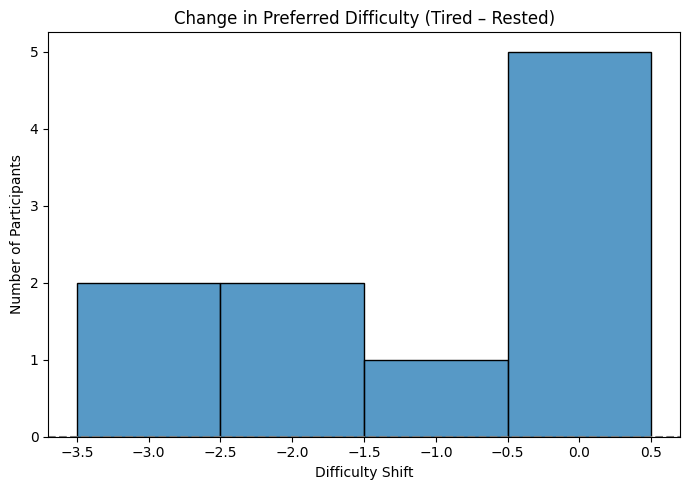

In [138]:
preferred_pivot["change"] = preferred_pivot["tired1"] - preferred_pivot["rested"]

plt.figure(figsize=(7, 5))
sns.histplot(preferred_pivot["change"], bins=np.arange(-5, 6) - 0.5, discrete=True)
plt.axhline(0, color="gray", linestyle="--")
plt.title("Change in Preferred Difficulty (Tired – Rested)")
plt.xlabel("Difficulty Shift")
plt.ylabel("Number of Participants")
plt.tight_layout()
plt.show()


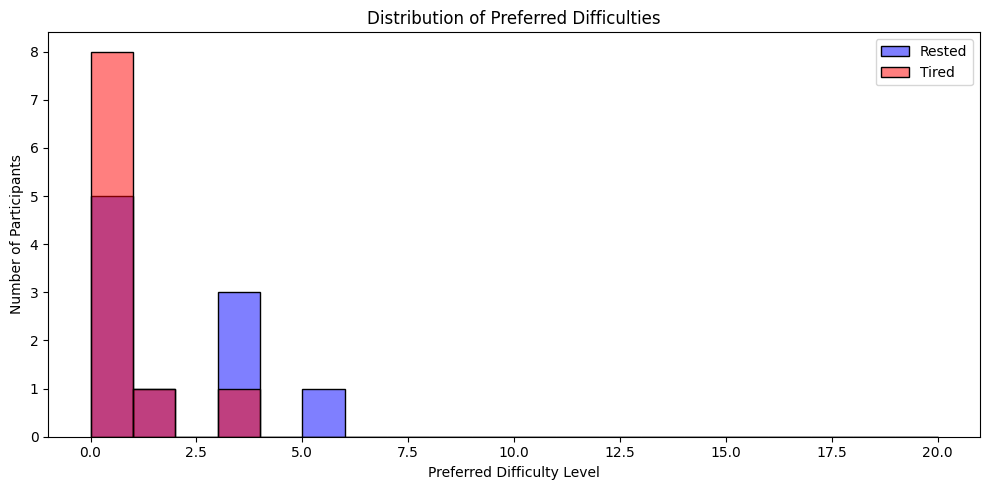

In [139]:
plt.figure(figsize=(10, 5))
sns.histplot(data=preferred_pivot, x="rested", bins=range(0, 21), label="Rested", color="blue", alpha=0.5)
sns.histplot(data=preferred_pivot, x="tired1", bins=range(0, 21), label="Tired", color="red", alpha=0.5)
plt.legend()
plt.title("Distribution of Preferred Difficulties")
plt.xlabel("Preferred Difficulty Level")
plt.ylabel("Number of Participants")
plt.tight_layout()
plt.show()


In [140]:
satisfaction_score_map = {
    "Very unsatisfying": 1,
    "Unsatisfying": 2,
    "Neutral": 3,
    "Satisfying": 4,
    "Very satisfying": 5
}


In [141]:
# Universal satisfaction label mapping (used by q8, q9, q10)
satisfaction_labels = {
    "q8o1": "Very unsatisfying",
    "q8o2": "Unsatisfying",
    "q8o3": "Neutral",
    "q8o4": "Satisfying",
    "q8o5": "Very satisfying"
}

# Extract satisfaction per game from the 'survey' dictionary
def extract_satisfaction(df, state_label):
    records = []
    for _, row in df.iterrows():
        survey = row["survey"]
        pid = row["participantCode"]

        for q_key, game_number in zip(["q8", "q9", "q10"], [1, 2, 3]):
            raw_answer = survey.get(q_key)
            if raw_answer:
                label = satisfaction_labels.get(raw_answer, "Unknown")
                records.append({
                    "participantCode": pid,
                    "state": state_label,
                    "game_number": game_number,
                    "satisfaction": label
                })
    return records

# Apply to both states
rested_records = extract_satisfaction(rested_common, "rested")
tired_records = extract_satisfaction(tired1_common, "tired1")

# Combine
satisfaction_df = pd.DataFrame(rested_records + tired_records)


In [142]:
satisfaction_df["satisfaction_score"] = satisfaction_df["satisfaction"].map(satisfaction_score_map)

In [143]:
# Only white moves, no checkmates
eval_clean = eval_df[
    (eval_df["color"] == "w") & (eval_df["eval_after"].abs() != 10000)
].copy()

# Aggregate to per-game level
performance_summary = (
    eval_clean.groupby(["participantCode", "state", "game_id", "difficulty"])
    .agg(
        avg_cp_delta=("cp_delta", "mean"),
        blunder_rate=("cp_delta", lambda x: (x > 300).mean())
    )
    .reset_index()
    .rename(columns={"game_id": "game_number"})
)


In [144]:
merged = pd.merge(
    satisfaction_df,
    performance_summary,
    on=["participantCode", "state", "game_number"],
    how="inner"
)


In [145]:
for state in ["rested", "tired1"]:
    subset = merged[merged["state"] == state]
    corr = subset[["difficulty", "avg_cp_delta", "satisfaction_score"]].corr()
    print(f"\nCorrelation matrix ({state}):\n", corr)



Correlation matrix (rested):
                     difficulty  avg_cp_delta  satisfaction_score
difficulty            1.000000      -0.21296            0.187643
avg_cp_delta         -0.212960       1.00000            0.300130
satisfaction_score    0.187643       0.30013            1.000000

Correlation matrix (tired1):
                     difficulty  avg_cp_delta  satisfaction_score
difficulty            1.000000     -0.171228            0.265327
avg_cp_delta         -0.171228      1.000000           -0.105753
satisfaction_score    0.265327     -0.105753            1.000000


# Predicting Fatigue

In [162]:
def extract_features(winsconsin_df):
    grouped = winsconsin_df.groupby(['participantCode', 'condition'])

    def participant_features(group):
        mean_time_correct = group.loc[group['trialType'] == 'correct', 'timeMs'].mean()
        mean_time_unexpected = group.loc[group['trialType'] == 'unexpected', 'timeMs'].mean()
        mean_time_rulechange = group.loc[group['trialType'] == 'rule-change-expected', 'timeMs'].mean()

        return pd.Series({
            'mean_time': group['timeMs'].mean(),
            'std_time': group['timeMs'].std(),
            'min_time': group['timeMs'].min(),
            'max_time': group['timeMs'].max(),
            'median_time': group['timeMs'].median(),
            'correct_rate': (group['trialType'] == 'correct').mean(),
            'unexpected_error_rate': (group['trialType'] == 'unexpected').mean(),
            'rulechange_error_rate': (group['trialType'] == 'rule-change-expected').mean(),
            'mean_time_correct': mean_time_correct,
            'mean_time_unexpected': mean_time_unexpected if pd.notna(mean_time_unexpected) else 100,
            'mean_time_rulechange': mean_time_rulechange,
            'trial_count': group.shape[0]
        })

    features_df = grouped.apply(participant_features).reset_index()

    features_df['label'] = features_df['condition'].map({'rested': 0, 'tired': 1})

    X = features_df.drop(columns=['participantCode', 'condition', 'label'])
    y = features_df['label']

    return X, y

In [163]:
X, y = extract_features(winsconsin_df)
X

/var/folders/v_/rx6dzypn6sxgjcqrs3v3nkhm0000gn/T/ipykernel_99436/3169305933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  features_df = grouped.apply(participant_features).reset_index()


,mean_time,std_time,min_time,max_time,median_time,correct_rate,unexpected_error_rate,rulechange_error_rate,mean_time_correct,mean_time_unexpected,mean_time_rulechange,trial_count
0,1625.092593,493.357166,825.0,3424.0,1581.5,0.833333,0.018519,0.148148,1579.066667,2034.000000,1832.875000,54.0
1,1430.907407,520.382779,745.0,3368.0,1311.5,0.833333,0.037037,0.129630,1386.733333,2647.000000,1367.428571,54.0
2,1393.759259,720.611898,777.0,4723.0,1157.0,0.888889,0.000000,0.111111,1417.833333,100.000000,1201.166667,54.0
3,1212.925926,348.954657,785.0,2465.0,1144.5,0.814815,0.037037,0.148148,1212.272727,1432.000000,1161.750000,54.0
4,1464.314815,480.670084,838.0,2935.0,1357.0,0.888889,0.018519,0.092593,1493.750000,1656.000000,1143.400000,54.0
5,1533.703704,514.878759,791.0,3528.0,1463.0,0.851852,0.018519,0.129630,1558.173913,1847.000000,1328.142857,54.0
6,1404.981481,577.384784,685.0,3466.0,1202.5,0.740741,0.037037,0.222222,1312.875000,1233.000000,1740.666667,54.0
7,1132.203704,350.037161,623.0,2120.0,1052.5,0.796296,0.055556,0.148148,1100.837209,1419.000000,1193.250000,54.0
8,1515.185185,656.185146,776.0,3874.0,1300.5,0.833333,0.037037,0.129630,1392.600000,2804.000000,1935.000000,54.0
9,1272.000000,367.504383,756.0,2614.0,1173.5,0.907407,0.000000,0.092593,1263.612245,100.000000,1354.200000,54.0


In [221]:
logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(random_state=42))
])

xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(
        eval_metric='logloss',
        random_state=42,
        max_depth=3,
        n_estimators=15,
        learning_rate=0.1,
    ))
])

In [222]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

logreg_scores = cross_val_score(logreg_pipeline, X, y, cv=cv, scoring='accuracy')
xgb_scores = cross_val_score(xgb_pipeline, X, y, cv=cv, scoring='accuracy')

print("Logistic Regression Accuracy: ", logreg_scores.mean())
print("XGBoost Accuracy: ", xgb_scores.mean())

Logistic Regression Accuracy:  0.49
XGBoost Accuracy:  0.735


In [223]:
logreg_pipeline.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg', LogisticRegression(random_state=42))])

In [224]:
xgb_pipeline.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=15, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [225]:
train_preds = xgb_pipeline.predict(X)
train_acc = accuracy_score(y, train_preds)

# Cross-validation
cv_scores = cross_val_score(xgb_pipeline, X, y, cv=cv, scoring='accuracy')

print(f"Training Accuracy: {train_acc:.2f}")
print(f"Cross-Val Accuracy (mean of folds): {cv_scores.mean():.2f}")

Training Accuracy: 1.00
Cross-Val Accuracy (mean of folds): 0.73


In [226]:
joblib.dump(logreg_pipeline, 'logreg_pipeline.pkl')
joblib.dump(xgb_pipeline, 'xgb_pipeline.pkl')
joblib.dump(X.columns.tolist(), 'feature_names.pkl')

['feature_names.pkl']

# Hierarchical Bayesian Model for difficulty adjustment

In [154]:
# Merge satisfaction and performance summaries
merged = pd.merge(
    satisfaction_df,
    performance_summary,
    on=["participantCode", "state", "game_number"],
    how="inner"
)

# Merge with perceived/actual difficulty
merged = pd.merge(
    merged,
    combined_survey_df[["participantCode", "state", "game", "actual_difficulty"]],
    left_on=["participantCode", "state", "game_number"],
    right_on=["participantCode", "state", "game"],
    how="left"
).drop(columns=["game"])

wisc_summary = (
    winsconsin_df[winsconsin_df['trialType'].isin(['correct', 'unexpected'])]
    .groupby(['participantCode', 'condition', 'trialType'])
    ['timeMs']
    .mean()
    .unstack(fill_value=np.nan)
    .rename(columns={"correct": "wisc_correct_rt", "unexpected": "wisc_incorrect_rt"})
    .reset_index()
    .rename(columns={"condition": "state"})
)
wisc_summary["state"] = wisc_summary["state"].replace("tired", "tired1")
# Final merge: add Wisconsin data
final_df = pd.merge(
    merged,
    wisc_summary,
    on=["participantCode", "state"],
    how="left"
)
final_df["wisc_incorrect_rt"] = final_df["wisc_incorrect_rt"].fillna(100)


In [155]:

# Map categorical columns to numeric
final_df["state_code"] = final_df["state"].map({"rested": 0, "tired1": 1})
final_df["satisfaction_score"] = final_df["satisfaction"].map({
    "Very unsatisfying": 1,
    "Unsatisfying": 2,
    "Neutral": 3,
    "Satisfying": 4,
    "Very satisfying": 5
})

# Encode participant codes as categorical index
final_df["participant_idx"] = final_df["participantCode"].astype("category").cat.codes
participant_idx = final_df["participant_idx"].values
n_participants = final_df["participant_idx"].nunique()

# Inputs for model
fatigue = final_df["state_code"].values
difficulty = final_df["difficulty"].values
cp_delta = final_df["avg_cp_delta"].values
blunder_rate = final_df["blunder_rate"].values
satisfaction = final_df["satisfaction_score"].values
wisc_correct_rt = final_df["wisc_correct_rt"].values
wisc_incorrect_rt = final_df["wisc_incorrect_rt"].values

In [156]:

# Copy to avoid modifying original
model_df = final_df.copy()

# Select columns to standardize
to_standardize = ["difficulty", "wisc_correct_rt", "wisc_incorrect_rt"]

# Drop rows with missing values in these columns just for standardization
model_df = model_df.dropna(subset=to_standardize)

# Initialize scaler and fit-transform
scaler = StandardScaler()
model_df[to_standardize] = scaler.fit_transform(model_df[to_standardize])

# Encode categorical variables
model_df["participant_idx"] = model_df["participantCode"].astype("category").cat.codes
model_df["fatigue"] = (model_df["state"] == "tired1").astype(int)
model_df["satisfaction_score"] = model_df["satisfaction_score"].astype(float)  # ensure numeric


In [157]:

X_difficulty = model_df["difficulty"].values
X_fatigue = model_df["fatigue"].values
X_wisc_correct = model_df["wisc_correct_rt"].values
X_wisc_incorrect = model_df["wisc_incorrect_rt"].values
y = model_df["satisfaction_score"].values

# Optional: participant as group-level hierarchy
participant_codes = model_df["participantCode"].astype("category").cat.codes.values
n_participants = len(np.unique(participant_codes))

with pm.Model() as satisfaction_model:
    # Hyperpriors for group-level (participant-specific) intercepts
    mu_alpha = pm.Normal("mu_alpha", mu=0, sigma=1)
    sigma_alpha = pm.Exponential("sigma_alpha", 1.0)
    alpha = pm.Normal("alpha", mu=mu_alpha, sigma=sigma_alpha, shape=n_participants)
    
    # Coefficients for predictors (shared across participants)
    beta_difficulty = pm.Normal("beta_difficulty", mu=0, sigma=1)
    beta_fatigue = pm.Normal("beta_fatigue", mu=0, sigma=1)
    beta_wisc_correct = pm.Normal("beta_wisc_correct", mu=0, sigma=1)
    beta_wisc_incorrect = pm.Normal("beta_wisc_incorrect", mu=0, sigma=1)

    # Model equation
    mu = (
        alpha[participant_codes]
        + beta_difficulty * X_difficulty
        + beta_fatigue * X_fatigue
        + beta_wisc_correct * X_wisc_correct
        + beta_wisc_incorrect * X_wisc_incorrect
    )

    # Likelihood (Gaussian for continuous satisfaction scores)
    sigma = pm.Exponential("sigma", 1.0)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

    trace = pm.sample(1000, tune=1000, target_accept=0.9, random_seed=42)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_alpha, sigma_alpha, alpha, beta_difficulty, beta_fatigue, beta_wisc_correct, beta_wisc_incorrect, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_alpha,1.96,0.33,1.34,2.57,0.01,0.01,3800.89,2854.44,1.0
alpha[0],1.36,0.26,0.88,1.87,0.00,0.00,3971.62,3002.42,1.0
alpha[1],2.56,0.29,2.05,3.16,0.00,0.00,3534.65,3038.05,1.0
alpha[2],2.57,0.25,2.07,3.03,0.00,0.00,3986.01,3212.92,1.0
alpha[3],2.60,0.32,1.96,3.17,0.01,0.00,2909.60,3171.64,1.0
alpha[4],2.89,0.28,2.38,3.42,0.00,0.00,3774.34,2890.17,1.0
alpha[5],0.92,0.29,0.40,1.49,0.00,0.00,4054.07,2661.13,1.0
alpha[6],2.23,0.49,1.31,3.12,0.01,0.01,2296.74,2725.71,1.0
alpha[7],2.97,0.27,2.46,3.48,0.00,0.00,3519.51,3133.40,1.0
alpha[8],0.81,0.26,0.31,1.30,0.00,0.00,4701.54,3122.34,1.0


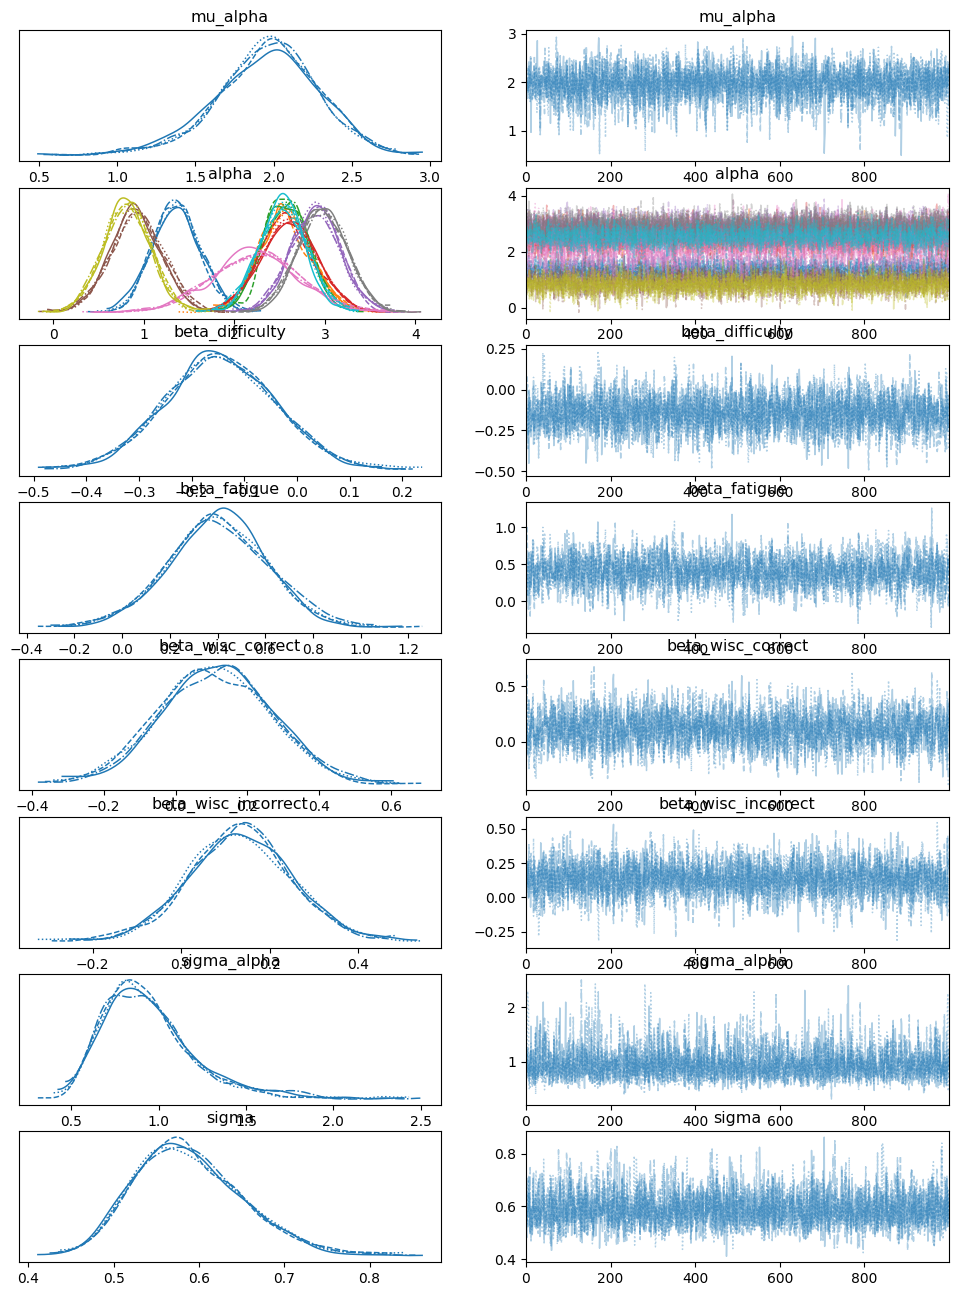

In [158]:
az.plot_trace(trace)
az.summary(trace, round_to=2)

In [159]:
# Save the model trace
with open("satisfaction_model_trace.pkl", "wb") as f:
    pickle.dump(trace, f)

# Save the model structure (optional in PyMC)
model_path = "satisfaction_model.netcdf"
az.to_netcdf(trace, model_path)

# Save the scaler
joblib.dump(scaler, "satisfaction_scaler.pkl")

participant_mapping = final_df.drop_duplicates("participantCode").set_index("participantCode")["participant_idx"].to_dict()
with open("participant_mapping.pkl", "wb") as f:
    pickle.dump(participant_mapping, f)
